In [1]:
import pandas as pd
from sqlalchemy import create_engine
from credentials import HOCKEY_DB_NAME, HOCKEY_DB_PWD
from schedule import get_schedule
from datetime import date
from betting_utils import convert_prob_to_american
import seaborn as sns


In [2]:
engine = create_engine('postgresql://baseball:{}@localhost:5432/{}'.format(HOCKEY_DB_PWD, HOCKEY_DB_NAME))

In [3]:
s = get_schedule(startdate = date.today(), enddate = date.today())
s

,game_pk,game_type,game_date,game_final,home_team,away_team,home_score,away_score
0,2022020365,R,2022-12-02T00:00:00Z,False,Buffalo Sabres,Colorado Avalanche,-1,-1
1,2022020366,R,2022-12-02T00:00:00Z,False,New Jersey Devils,Nashville Predators,-1,-1
2,2022020367,R,2022-12-02T00:00:00Z,False,Philadelphia Flyers,Tampa Bay Lightning,-1,-1
3,2022020368,R,2022-12-02T00:00:00Z,False,Pittsburgh Penguins,Vegas Golden Knights,-1,-1
4,2022020369,R,2022-12-02T01:00:00Z,False,St. Louis Blues,Carolina Hurricanes,-1,-1
5,2022020370,R,2022-12-02T01:00:00Z,False,Minnesota Wild,Edmonton Oilers,-1,-1
6,2022020371,R,2022-12-02T01:30:00Z,False,Dallas Stars,Anaheim Ducks,-1,-1
7,2022020372,R,2022-12-02T02:00:00Z,False,Calgary Flames,Montréal Canadiens,-1,-1
8,2022020373,R,2022-12-02T03:00:00Z,False,Vancouver Canucks,Florida Panthers,-1,-1
9,2022020374,R,2022-12-02T03:00:00Z,False,Seattle Kraken,Washington Capitals,-1,-1


In [4]:
dat = pd.read_sql("""SELECT b.* FROM nhl_player_boxscore b
     INNER JOIN nhl_schedule s ON b.game_pk = s.game_pk
     WHERE s.game_date >= '2021-06-01' AND player_name IN ('Trevor Zegras');""", engine)
        
dat['scored_goal'] = dat['goals'] >= 1
dat['scored_assist'] = dat['assists'] >= 1
dat['total_points'] = dat['goals'] + dat['assists']
dat['one_point'] = dat['total_points'] >= 1
dat['two_points'] = dat['total_points'] >= 2

dat.groupby(['player_name', 'one_point'])['shots'].describe()

dat.groupby(['player_name', 'scored_assist'])['game_pk'].nunique()

player_name    scored_assist
Trevor Zegras  False            61
               True             37
Name: game_pk, dtype: int64

In [5]:
#for i in range(s.shape[0]):
#    team_one = s.loc[i]['away_team']
#    team_two = s.loc[i]['home_team']

#    dat = pd.read_sql("""SELECT b.* FROM nhl_player_boxscore b
#     INNER JOIN nhl_schedule s ON b.game_pk = s.game_pk
#     WHERE s.game_date >= '2021-06-01' AND (b.team = \'{}\') OR (b.team = \'{}\');""".format(team_one, team_two), engine)
        
#    dat['scored_goal'] = dat['goals'] >= 1
#    dat['scored_assist'] = dat['assists'] >= 1

#    players = dat.groupby('player_name')['goals'].sum().sort_values().tail(15).reset_index()['player_name']
    
#    lvk = pd.pivot_table(dat[dat['player_name'].isin(players)], index = ['game_pk'], columns = 'player_name', values = ['scored_goal'])
#    lvk.columns = [' '.join(col).strip() for col in lvk.columns.values]
#    print(team_one, team_two)
#    display(lvk.corr())

### Goals

In [17]:
def format_results(team, variable):
    cm = sns.light_palette("blue", as_cmap=True, reverse = True)

    dat = pd.read_sql("""SELECT b.* FROM nhl_player_boxscore b
     INNER JOIN nhl_schedule s ON b.game_pk = s.game_pk
     WHERE s.game_date >= '2021-06-01' AND b.team = \'{}\';""".format(team), engine)
        
    dat['scored_goal'] = dat['goals'] >= 1
    dat['scored_assist'] = dat['assists'] >= 1
    dat['scored_point'] = (dat['goals'] + dat['assists']) >= 1

    players = dat.groupby('player_name')[variable[0]].sum().sort_values().tail(8).reset_index()['player_name']
    
    lvk = pd.pivot_table(dat[dat['player_name'].isin(players)], index = ['game_pk'], columns = 'player_name', values = variable)
    lvk.columns = [' '.join(col).strip() for col in lvk.columns.values]
    print(team)
#    g = lvk.mean().apply(convert_prob_to_american).to_frame(name = 'fair_odds')
#    display(g.style.background_gradient(cmap=cm)) 
    
    corr = lvk.corr(min_periods = 12)
    display(corr.style.background_gradient(cmap = cm))


In [19]:
for i in range(s.shape[0]):
    team_one = s.loc[i]['away_team']
    team_two = s.loc[i]['home_team']

    format_results(team_one, ['scored_goal', 'scored_point'])

    format_results(team_two, ['scored_goal', 'scored_point'])

Colorado Avalanche


,scored_goal Alex Newhook,scored_goal Cale Makar,scored_goal Gabriel Landeskog,scored_goal J.T. Compher,scored_goal Mikko Rantanen,scored_goal Nathan MacKinnon,scored_goal Nazem Kadri,scored_goal Valeri Nichushkin,scored_point Alex Newhook,scored_point Cale Makar,scored_point Gabriel Landeskog,scored_point J.T. Compher,scored_point Mikko Rantanen,scored_point Nathan MacKinnon,scored_point Nazem Kadri,scored_point Valeri Nichushkin
scored_goal Alex Newhook,1.000000,0.082188,-0.119286,0.115672,0.021170,-0.086280,0.228598,-0.022213,0.606274,0.024056,0.170630,0.027180,0.017285,-0.123282,0.090909,0.150718
scored_goal Cale Makar,0.082188,1.000000,-0.089087,0.269899,-0.145848,0.027295,-0.009854,0.036236,0.151131,0.416005,0.132599,0.261785,0.016038,0.167968,0.229822,-0.124882
scored_goal Gabriel Landeskog,-0.119286,-0.089087,1.000000,-0.201008,-0.075903,-0.025482,0.035960,0.243562,-0.121739,-0.018735,0.535766,-0.219458,0.126227,0.100728,0.273861,0.331133
scored_goal J.T. Compher,0.115672,0.269899,-0.201008,1.000000,0.028515,0.082295,-0.046650,-0.228315,0.263031,0.061920,-0.053376,0.682461,0.175417,0.100007,0.010146,-0.297549
scored_goal Mikko Rantanen,0.021170,-0.145848,-0.075903,0.028515,1.000000,-0.025265,0.032530,-0.015121,-0.110433,0.108499,0.084732,0.157060,0.554700,0.237028,-0.078811,-0.115931
scored_goal Nathan MacKinnon,-0.086280,0.027295,-0.025482,0.082295,-0.025265,1.000000,-0.176535,-0.168717,0.181444,0.128777,0.158114,-0.042258,0.140613,0.385239,-0.045458,-0.022157
scored_goal Nazem Kadri,0.228598,-0.009854,0.035960,-0.046650,0.032530,-0.176535,1.000000,-0.050350,0.185450,-0.239523,0.157568,0.047619,0.104447,0.021443,0.490552,0.036927
scored_goal Valeri Nichushkin,-0.022213,0.036236,0.243562,-0.228315,-0.015121,-0.168717,-0.050350,1.000000,0.018904,0.189122,0.184637,-0.027608,0.233778,0.152331,0.046676,0.586133
scored_point Alex Newhook,0.606274,0.151131,-0.121739,0.263031,-0.110433,0.181444,0.185450,0.018904,1.000000,0.066694,0.021323,0.125048,0.028094,0.027778,0.126428,-0.027163
scored_point Cale Makar,0.024056,0.416005,-0.018735,0.061920,0.108499,0.128777,-0.239523,0.189122,0.066694,1.000000,0.113866,0.000000,0.176431,0.286411,-0.005594,0.038782


Buffalo Sabres


,scored_goal Alex Tuch,scored_goal Dylan Cozens,scored_goal Jeff Skinner,scored_goal Kyle Okposo,scored_goal Rasmus Dahlin,scored_goal Tage Thompson,scored_goal Victor Olofsson,scored_goal Zemgus Girgensons,scored_point Alex Tuch,scored_point Dylan Cozens,scored_point Jeff Skinner,scored_point Kyle Okposo,scored_point Rasmus Dahlin,scored_point Tage Thompson,scored_point Victor Olofsson,scored_point Zemgus Girgensons
scored_goal Alex Tuch,1.000000,-0.021918,-0.182726,0.152778,0.307570,-0.156139,0.065789,0.131703,0.542700,0.102553,-0.034819,0.029361,0.204019,0.189275,0.080220,0.044156
scored_goal Dylan Cozens,-0.021918,1.000000,0.133288,-0.206420,-0.053558,-0.143351,-0.158193,-0.117902,0.100293,0.571859,0.066176,-0.097497,0.094024,-0.077883,-0.156203,-0.076159
scored_goal Jeff Skinner,-0.182726,0.133288,1.000000,0.050347,0.109109,-0.023282,-0.063056,-0.064428,0.268882,0.159447,0.637326,0.091621,0.297731,0.339650,0.071587,0.016675
scored_goal Kyle Okposo,0.152778,-0.206420,0.050347,1.000000,-0.006111,0.242536,0.058870,-0.010455,0.156213,-0.019189,0.101254,0.558488,0.222783,0.188639,0.243161,0.178638
scored_goal Rasmus Dahlin,0.307570,-0.053558,0.109109,-0.006111,1.000000,0.064689,-0.091570,0.037582,0.269569,-0.055411,0.130104,0.124244,0.456537,0.204791,0.167990,0.162682
scored_goal Tage Thompson,-0.156139,-0.143351,-0.023282,0.242536,0.064689,1.000000,-0.005114,-0.043006,0.215881,0.123119,0.365912,0.215402,0.239437,0.629032,0.062419,0.120348
scored_goal Victor Olofsson,0.065789,-0.158193,-0.063056,0.058870,-0.091570,-0.005114,1.000000,-0.107156,-0.109319,0.025491,0.081698,-0.069838,-0.080773,0.031017,0.634908,-0.101587
scored_goal Zemgus Girgensons,0.131703,-0.117902,-0.064428,-0.010455,0.037582,-0.043006,-0.107156,1.000000,0.194530,-0.128466,0.109659,0.266748,0.085010,-0.007729,0.101968,0.702500
scored_point Alex Tuch,0.542700,0.100293,0.268882,0.156213,0.269569,0.215881,-0.109319,0.194530,1.000000,0.215881,0.281784,0.187435,0.306298,0.420486,0.038244,0.230667
scored_point Dylan Cozens,0.102553,0.571859,0.159447,-0.019189,-0.055411,0.123119,0.025491,-0.128466,0.215881,1.000000,0.142986,0.097647,0.230543,0.090811,-0.023234,-0.138572


Nashville Predators


,scored_goal Eeli Tolvanen,scored_goal Filip Forsberg,scored_goal Matt Duchene,scored_goal Mikael Granlund,scored_goal Roman Josi,scored_goal Ryan Johansen,scored_goal Tanner Jeannot,scored_goal Yakov Trenin,scored_point Eeli Tolvanen,scored_point Filip Forsberg,scored_point Matt Duchene,scored_point Mikael Granlund,scored_point Roman Josi,scored_point Ryan Johansen,scored_point Tanner Jeannot,scored_point Yakov Trenin
scored_goal Eeli Tolvanen,1.000000,-0.259596,-0.024057,0.225692,0.196116,0.093679,0.050176,0.189839,0.660057,0.067194,-0.047255,0.119108,0.254045,-0.028506,0.134282,0.204302
scored_goal Filip Forsberg,-0.259596,1.000000,0.036561,-0.190764,-0.079472,-0.047091,0.162302,0.121927,-0.246922,0.557370,0.258209,0.223564,0.134402,0.074651,0.205304,0.098502
scored_goal Matt Duchene,-0.024057,0.036561,1.000000,0.062119,-0.019678,-0.126708,-0.127018,-0.064204,0.038480,0.216198,0.570834,0.314488,0.179370,0.037155,-0.096076,-0.071885
scored_goal Mikael Granlund,0.225692,-0.190764,0.062119,1.000000,0.255883,0.023841,0.010049,0.068727,0.147483,0.169450,0.092247,0.337691,0.238532,0.170344,-0.034288,0.078888
scored_goal Roman Josi,0.196116,-0.079472,-0.019678,0.255883,1.000000,0.110669,-0.012811,-0.080423,0.209083,0.130931,0.210023,0.239143,0.447679,0.057627,-0.017099,0.065336
scored_goal Ryan Johansen,0.093679,-0.047091,-0.126708,0.023841,0.110669,1.000000,0.149854,-0.067821,-0.050000,-0.029339,0.029102,0.001799,0.138264,0.564076,0.098567,0.112748
scored_goal Tanner Jeannot,0.050176,0.162302,-0.127018,0.010049,-0.012811,0.149854,1.000000,0.120796,-0.023203,0.066039,0.124618,0.168712,0.139672,0.048795,0.735215,0.311594
scored_goal Yakov Trenin,0.189839,0.121927,-0.064204,0.068727,-0.080423,-0.067821,0.120796,1.000000,0.118740,0.147412,0.023741,0.134594,0.056063,-0.151057,0.484442,0.826434
scored_point Eeli Tolvanen,0.660057,-0.246922,0.038480,0.147483,0.209083,-0.050000,-0.023203,0.118740,1.000000,0.015952,0.017552,0.143475,0.203771,0.015215,0.021431,0.096959
scored_point Filip Forsberg,0.067194,0.557370,0.216198,0.169450,0.130931,-0.029339,0.066039,0.147412,0.015952,1.000000,0.421277,0.374898,0.204762,0.083214,0.069424,0.222385


New Jersey Devils


,scored_goal Dawson Mercer,scored_goal Dougie Hamilton,scored_goal Jack Hughes,scored_goal Jesper Bratt,scored_goal Nico Hischier,scored_goal Pavel Zacha,scored_goal Tomas Tatar,scored_goal Yegor Sharangovich,scored_point Dawson Mercer,scored_point Dougie Hamilton,scored_point Jack Hughes,scored_point Jesper Bratt,scored_point Nico Hischier,scored_point Pavel Zacha,scored_point Tomas Tatar,scored_point Yegor Sharangovich
scored_goal Dawson Mercer,1.000000,0.104257,-0.031656,0.007817,-0.022024,-0.003799,0.046620,0.305776,0.618207,0.067026,0.178697,0.231232,0.223330,0.104777,0.160702,0.262867
scored_goal Dougie Hamilton,0.104257,1.000000,0.057079,0.042273,-0.165434,-0.079365,-0.094039,-0.132317,0.161515,0.525496,0.015668,0.130152,-0.088629,0.200653,0.010210,-0.046762
scored_goal Jack Hughes,-0.031656,0.057079,1.000000,0.022598,-0.101617,-0.013577,-0.021664,0.095969,0.093627,0.152798,0.557973,0.148627,-0.099782,0.019263,0.107759,0.199746
scored_goal Jesper Bratt,0.007817,0.042273,0.022598,1.000000,-0.151456,-0.095653,-0.062140,0.004089,0.058023,-0.044667,0.101039,0.434587,-0.036049,0.095538,0.012490,-0.006694
scored_goal Nico Hischier,-0.022024,-0.165434,-0.101617,-0.151456,1.000000,0.154656,-0.127610,0.058418,0.039365,0.141316,0.032661,-0.084827,0.471525,0.122007,0.033541,0.049166
scored_goal Pavel Zacha,-0.003799,-0.079365,-0.013577,-0.095653,0.154656,1.000000,-0.147452,-0.017857,0.186208,0.012218,0.249068,0.002462,0.266671,0.575247,0.102159,0.079057
scored_goal Tomas Tatar,0.046620,-0.094039,-0.021664,-0.062140,-0.127610,-0.147452,1.000000,0.108921,0.126645,0.015431,-0.033201,0.097606,0.119830,-0.108465,0.643585,0.098397
scored_goal Yegor Sharangovich,0.305776,-0.132317,0.095969,0.004089,0.058418,-0.017857,0.108921,1.000000,0.206334,-0.196457,0.204167,0.182299,0.334113,0.007767,0.257078,0.708543
scored_point Dawson Mercer,0.618207,0.161515,0.093627,0.058023,0.039365,0.186208,0.126645,0.206334,1.000000,0.055380,0.249417,0.200857,0.254128,0.195336,0.220853,0.221603
scored_point Dougie Hamilton,0.067026,0.525496,0.152798,-0.044667,0.141316,0.012218,0.015431,-0.196457,0.055380,1.000000,0.039784,-0.094758,-0.108436,0.085804,0.145014,-0.114594


Tampa Bay Lightning


,scored_goal Alex Killorn,scored_goal Anthony Cirelli,scored_goal Brayden Point,scored_goal Corey Perry,scored_goal Nikita Kucherov,scored_goal Ross Colton,scored_goal Steven Stamkos,scored_goal Victor Hedman,scored_point Alex Killorn,scored_point Anthony Cirelli,scored_point Brayden Point,scored_point Corey Perry,scored_point Nikita Kucherov,scored_point Ross Colton,scored_point Steven Stamkos,scored_point Victor Hedman
scored_goal Alex Killorn,1.000000,0.011093,-0.021852,-0.055920,-0.071824,0.152691,-0.189043,0.126357,0.556064,0.174118,0.093133,-0.029839,0.158904,0.108288,0.028177,0.081092
scored_goal Anthony Cirelli,0.011093,1.000000,-0.054074,-0.187500,0.238869,-0.120614,0.040437,0.129167,0.334801,0.589470,0.221703,-0.059865,0.131493,-0.077428,0.214599,0.281389
scored_goal Brayden Point,-0.021852,-0.054074,1.000000,0.198887,-0.150034,-0.195837,0.184718,-0.218410,0.220589,0.062776,0.599824,0.048827,0.149478,-0.124772,0.137607,0.148993
scored_goal Corey Perry,-0.055920,-0.187500,0.198887,1.000000,-0.093898,0.111994,0.003355,-0.162650,0.052529,0.068543,0.154198,0.676873,0.084877,0.145995,0.172244,0.091449
scored_goal Nikita Kucherov,-0.071824,0.238869,-0.150034,-0.093898,1.000000,0.055902,0.038169,0.069713,0.045764,-0.023234,0.077501,-0.098191,0.501477,-0.050952,0.230089,0.140886
scored_goal Ross Colton,0.152691,-0.120614,-0.195837,0.111994,0.055902,1.000000,-0.059540,0.089131,0.033070,0.132557,-0.093781,0.217630,0.007380,0.678372,0.086992,0.150232
scored_goal Steven Stamkos,-0.189043,0.040437,0.184718,0.003355,0.038169,-0.059540,1.000000,-0.145732,0.082569,0.127907,0.293968,0.078734,0.210775,-0.175483,0.522015,0.053635
scored_goal Victor Hedman,0.126357,0.129167,-0.218410,-0.162650,0.069713,0.089131,-0.145732,1.000000,0.079472,0.133659,0.143963,-0.118550,0.147976,0.254691,0.022772,0.344601
scored_point Alex Killorn,0.556064,0.334801,0.220589,0.052529,0.045764,0.033070,0.082569,0.079472,1.000000,0.361084,0.342508,0.081466,0.109199,0.029883,0.254170,0.254643
scored_point Anthony Cirelli,0.174118,0.589470,0.062776,0.068543,-0.023234,0.132557,0.127907,0.133659,0.361084,1.000000,0.406961,0.046344,0.232348,0.041221,0.378517,0.366709


Philadelphia Flyers


,scored_goal Cam Atkinson,scored_goal Claude Giroux,scored_goal James van Riemsdyk,scored_goal Joel Farabee,scored_goal Kevin Hayes,scored_goal Oskar Lindblom,scored_goal Scott Laughton,scored_goal Travis Konecny,scored_point Cam Atkinson,scored_point Claude Giroux,scored_point James van Riemsdyk,scored_point Joel Farabee,scored_point Kevin Hayes,scored_point Oskar Lindblom,scored_point Scott Laughton,scored_point Travis Konecny
scored_goal Cam Atkinson,1.000000,0.214341,-0.213568,-0.088315,0.003807,0.138885,0.015585,0.023212,0.558573,0.257935,-0.086447,0.186171,-0.105507,-0.059391,-0.016541,-0.183415
scored_goal Claude Giroux,0.214341,1.000000,-0.066158,-0.020300,0.036274,-0.045094,0.104732,0.143343,0.427832,0.528221,0.169031,0.216600,0.019968,0.153018,0.110282,0.287352
scored_goal James van Riemsdyk,-0.213568,-0.066158,1.000000,-0.139456,-0.124758,0.022351,0.009650,0.133744,0.073491,0.128835,0.704265,-0.137164,0.219107,-0.015977,0.000000,0.193109
scored_goal Joel Farabee,-0.088315,-0.020300,-0.139456,1.000000,-0.055319,0.011990,0.166249,-0.017857,0.176838,-0.035806,-0.086066,0.689426,-0.014965,0.107843,0.053877,0.101534
scored_goal Kevin Hayes,0.003807,0.036274,-0.124758,-0.055319,1.000000,-0.232495,-0.159152,-0.167975,0.030929,0.128446,-0.148063,0.111489,0.461368,-0.061381,0.076015,0.116556
scored_goal Oskar Lindblom,0.138885,-0.045094,0.022351,0.011990,-0.232495,1.000000,-0.094276,-0.002539,0.117760,-0.210538,-0.018665,0.122975,-0.133631,0.660364,0.064875,0.209478
scored_goal Scott Laughton,0.015585,0.104732,0.009650,0.166249,-0.159152,-0.094276,1.000000,0.044179,-0.027314,0.264236,0.248493,0.020667,0.171116,-0.019430,0.572822,0.184522
scored_goal Travis Konecny,0.023212,0.143343,0.133744,-0.017857,-0.167975,-0.002539,0.044179,1.000000,0.026034,0.221792,0.307255,0.006435,0.228577,0.009987,0.099222,0.447214
scored_point Cam Atkinson,0.558573,0.427832,0.073491,0.176838,0.030929,0.117760,-0.027314,0.026034,1.000000,0.475199,0.152385,0.396284,-0.134921,0.093522,-0.041067,-0.109972
scored_point Claude Giroux,0.257935,0.528221,0.128835,-0.035806,0.128446,-0.210538,0.264236,0.221792,0.475199,1.000000,0.325000,0.061802,0.128788,-0.011411,0.085175,0.216250


Vegas Golden Knights


,scored_goal Chandler Stephenson,scored_goal Evgenii Dadonov,scored_goal Jack Eichel,scored_goal Jonathan Marchessault,scored_goal Nicolas Roy,scored_goal Reilly Smith,scored_goal William Carrier,scored_goal William Karlsson,scored_point Chandler Stephenson,scored_point Evgenii Dadonov,scored_point Jack Eichel,scored_point Jonathan Marchessault,scored_point Nicolas Roy,scored_point Reilly Smith,scored_point William Carrier,scored_point William Karlsson
scored_goal Chandler Stephenson,1.000000,0.155315,-0.014283,-0.012403,0.062676,0.102776,-0.001736,-0.016618,0.525010,0.078424,0.137115,0.134372,0.234091,0.139535,-0.014285,0.053376
scored_goal Evgenii Dadonov,0.155315,1.000000,0.233299,-0.084215,0.234883,0.066078,-0.130467,0.013558,0.260885,0.711967,0.340975,0.097590,0.290010,-0.035411,-0.097673,-0.072548
scored_goal Jack Eichel,-0.014283,0.233299,1.000000,0.243880,-0.076472,-0.308424,-0.055048,0.296730,0.216302,0.279290,0.567131,0.230048,0.081745,-0.229686,-0.106572,0.075454
scored_goal Jonathan Marchessault,-0.012403,-0.084215,0.243880,1.000000,-0.018858,-0.124179,-0.103606,0.096986,0.126369,0.076465,0.259416,0.609560,0.184900,0.304481,0.048626,0.176726
scored_goal Nicolas Roy,0.062676,0.234883,-0.076472,-0.018858,1.000000,-0.078970,-0.087264,0.057492,0.079410,0.166475,-0.055670,-0.087215,0.591872,0.036310,0.077743,0.115195
scored_goal Reilly Smith,0.102776,0.066078,-0.308424,-0.124179,-0.078970,1.000000,0.135780,-0.091287,0.117851,-0.030628,0.206584,0.170288,0.022749,0.571300,0.350070,0.353393
scored_goal William Carrier,-0.001736,-0.130467,-0.055048,-0.103606,-0.087264,0.135780,1.000000,0.036866,0.048702,-0.110549,0.021995,-0.008329,0.051107,0.030083,0.687059,0.129619
scored_goal William Karlsson,-0.016618,0.013558,0.296730,0.096986,0.057492,-0.091287,0.036866,1.000000,-0.084939,0.285391,0.196908,0.290037,0.081992,0.200024,0.042275,0.586436
scored_point Chandler Stephenson,0.525010,0.260885,0.216302,0.126369,0.079410,0.117851,0.048702,-0.084939,1.000000,0.283060,0.295656,0.244156,0.275899,0.293043,0.061688,-0.002115
scored_point Evgenii Dadonov,0.078424,0.711967,0.279290,0.076465,0.166475,-0.030628,-0.110549,0.285391,0.283060,1.000000,0.377862,0.211891,0.416864,0.026261,0.010992,0.165434


Pittsburgh Penguins


,scored_goal Brock McGinn,scored_goal Bryan Rust,scored_goal Danton Heinen,scored_goal Evan Rodrigues,scored_goal Evgeni Malkin,scored_goal Jake Guentzel,scored_goal Jeff Carter,scored_goal Sidney Crosby,scored_point Brock McGinn,scored_point Bryan Rust,scored_point Danton Heinen,scored_point Evan Rodrigues,scored_point Evgeni Malkin,scored_point Jake Guentzel,scored_point Jeff Carter,scored_point Sidney Crosby
scored_goal Brock McGinn,1.000000,-0.034801,0.237535,0.017719,0.136367,0.018380,-0.024642,0.091652,0.741410,-0.134920,0.223951,0.206725,0.146760,0.007380,0.100855,0.019627
scored_goal Bryan Rust,-0.034801,1.000000,0.035384,0.396801,-0.059798,-0.016016,0.138220,0.043048,0.074578,0.655601,0.011323,0.478667,0.140654,0.296236,0.131095,0.206107
scored_goal Danton Heinen,0.237535,0.035384,1.000000,-0.126455,0.103280,0.099752,0.142096,0.204980,0.329574,-0.074899,0.687326,0.208020,-0.022422,0.066621,0.133037,0.050521
scored_goal Evan Rodrigues,0.017719,0.396801,-0.126455,1.000000,-0.094529,-0.080894,0.130437,-0.105810,0.104447,0.126063,0.031003,0.648230,0.047393,0.181568,0.167360,0.016441
scored_goal Evgeni Malkin,0.136367,-0.059798,0.103280,-0.094529,1.000000,-0.197674,-0.029058,-0.086882,0.291504,0.224227,0.023570,0.079820,0.504964,0.045283,0.076472,-0.058948
scored_goal Jake Guentzel,0.018380,-0.016016,0.099752,-0.080894,-0.197674,1.000000,-0.071429,-0.072311,-0.116537,0.005446,0.180839,-0.014932,-0.029254,0.506607,0.098209,0.244766
scored_goal Jeff Carter,-0.024642,0.138220,0.142096,0.130437,-0.029058,-0.071429,1.000000,-0.119523,-0.060934,0.065897,0.153231,0.171868,0.071299,0.105925,0.516047,-0.064550
scored_goal Sidney Crosby,0.091652,0.043048,0.204980,-0.105810,-0.086882,-0.072311,-0.119523,1.000000,0.120733,0.064194,0.119523,0.062994,0.024158,0.152043,0.053467,0.540655
scored_point Brock McGinn,0.741410,0.074578,0.329574,0.104447,0.291504,-0.116537,-0.060934,0.120733,1.000000,-0.066336,0.274197,0.243709,0.184795,0.005331,0.147692,-0.038782
scored_point Bryan Rust,-0.134920,0.655601,-0.074899,0.126063,0.224227,0.005446,0.065897,0.064194,-0.066336,1.000000,-0.149436,0.215829,0.287094,0.317615,-0.071429,0.183072


Carolina Hurricanes


,scored_goal Andrei Svechnikov,scored_goal Jordan Staal,scored_goal Martin Necas,scored_goal Nino Niederreiter,scored_goal Sebastian Aho,scored_goal Seth Jarvis,scored_goal Teuvo Teravainen,scored_goal Vincent Trocheck,scored_point Andrei Svechnikov,scored_point Jordan Staal,scored_point Martin Necas,scored_point Nino Niederreiter,scored_point Sebastian Aho,scored_point Seth Jarvis,scored_point Teuvo Teravainen,scored_point Vincent Trocheck
scored_goal Andrei Svechnikov,1.000000,0.157788,-0.118214,-0.116535,-0.097348,-0.045573,-0.005095,-0.172938,0.575863,0.140660,0.065383,-0.029381,0.116712,0.091644,0.191628,0.022732
scored_goal Jordan Staal,0.157788,1.000000,-0.182468,-0.198870,0.127294,-0.074467,0.007988,0.016481,0.077951,0.622799,-0.125973,0.019073,0.123967,-0.018124,0.231700,-0.021538
scored_goal Martin Necas,-0.118214,-0.182468,1.000000,0.007363,-0.010768,0.084988,-0.012588,-0.020174,0.103630,-0.288063,0.596744,0.022346,0.169587,0.256229,-0.117827,0.128915
scored_goal Nino Niederreiter,-0.116535,-0.198870,0.007363,1.000000,-0.153160,0.095502,0.021031,0.159140,-0.161594,-0.103561,0.177595,0.670586,-0.031776,0.026377,-0.026861,0.212864
scored_goal Sebastian Aho,-0.097348,0.127294,-0.010768,-0.153160,1.000000,-0.031195,-0.200711,0.103894,0.076102,0.093929,0.039682,-0.005508,0.510117,0.088164,0.280863,0.113855
scored_goal Seth Jarvis,-0.045573,-0.074467,0.084988,0.095502,-0.031195,1.000000,0.019645,-0.029558,0.239066,0.073721,0.150617,-0.008948,0.077009,0.554861,-0.032346,-0.137755
scored_goal Teuvo Teravainen,-0.005095,0.007988,-0.012588,0.021031,-0.200711,0.019645,1.000000,-0.051788,0.060888,0.107045,0.093289,-0.014692,0.330561,0.148103,0.429394,-0.117028
scored_goal Vincent Trocheck,-0.172938,0.016481,-0.020174,0.159140,0.103894,-0.029558,-0.051788,1.000000,0.106299,0.044264,0.139122,0.108728,0.170470,-0.044979,0.090194,0.624418
scored_point Andrei Svechnikov,0.575863,0.077951,0.103630,-0.161594,0.076102,0.239066,0.060888,0.106299,1.000000,0.095504,0.174339,-0.207409,0.271304,0.251663,0.289216,0.188745
scored_point Jordan Staal,0.140660,0.622799,-0.288063,-0.103561,0.093929,0.073721,0.107045,0.044264,0.095504,1.000000,-0.198874,0.120245,0.207894,0.042509,0.299295,-0.050538


St. Louis Blues


,scored_goal Brandon Saad,scored_goal Brayden Schenn,scored_goal Ivan Barbashev,scored_goal Jordan Kyrou,scored_goal Pavel Buchnevich,scored_goal Robert Thomas,scored_goal Ryan O'Reilly,scored_goal Vladimir Tarasenko,scored_point Brandon Saad,scored_point Brayden Schenn,scored_point Ivan Barbashev,scored_point Jordan Kyrou,scored_point Pavel Buchnevich,scored_point Robert Thomas,scored_point Ryan O'Reilly,scored_point Vladimir Tarasenko
scored_goal Brandon Saad,1.000000,0.005561,-0.057804,-0.122798,-0.087773,0.087883,0.169971,-0.006875,0.643374,-0.006268,-0.011157,-0.134549,-0.102852,0.121174,0.102858,0.016835
scored_goal Brayden Schenn,0.005561,1.000000,-0.120094,0.041992,0.143702,-0.045556,0.003961,0.091574,-0.029585,0.553626,0.007291,0.228785,0.085714,0.031130,0.080904,0.169204
scored_goal Ivan Barbashev,-0.057804,-0.120094,1.000000,-0.057049,0.101780,-0.074760,0.076980,0.101886,0.027315,-0.075241,0.601855,0.004731,0.116333,0.170098,0.288675,0.134538
scored_goal Jordan Kyrou,-0.122798,0.041992,-0.057049,1.000000,-0.132288,-0.111319,-0.034536,0.016504,-0.041820,0.079948,-0.058408,0.509609,0.086213,0.037364,0.084956,0.129194
scored_goal Pavel Buchnevich,-0.087773,0.143702,0.101780,-0.132288,1.000000,0.142214,-0.255884,-0.075593,-0.067824,-0.064481,0.112061,0.071842,0.533687,0.438039,-0.192018,0.059761
scored_goal Robert Thomas,0.087883,-0.045556,-0.074760,-0.111319,0.142214,1.000000,-0.011718,-0.098433,0.170389,0.006665,0.049590,0.027509,0.219323,0.412823,-0.032709,0.047253
scored_goal Ryan O'Reilly,0.169971,0.003961,0.076980,-0.034536,-0.255884,-0.011718,1.000000,-0.249083,0.224068,0.082150,0.147143,0.148129,-0.076472,-0.237107,0.561951,-0.142509
scored_goal Vladimir Tarasenko,-0.006875,0.091574,0.101886,0.016504,-0.075593,-0.098433,-0.249083,1.000000,-0.071203,0.145948,0.239202,0.008698,0.159901,0.328156,-0.063238,0.566947
scored_point Brandon Saad,0.643374,-0.029585,0.027315,-0.041820,-0.067824,0.170389,0.224068,-0.071203,1.000000,0.023947,0.107878,0.016350,-0.060200,0.127536,0.188104,-0.087874
scored_point Brayden Schenn,-0.006268,0.553626,-0.075241,0.079948,-0.064481,0.006665,0.082150,0.145948,0.023947,1.000000,-0.062752,0.189942,0.129354,0.187981,0.025658,0.274951


Edmonton Oilers


,scored_goal Connor McDavid,scored_goal Evan Bouchard,scored_goal Evander Kane,scored_goal Kailer Yamamoto,scored_goal Leon Draisaitl,scored_goal Ryan Nugent-Hopkins,scored_goal Warren Foegele,scored_goal Zach Hyman,scored_point Connor McDavid,scored_point Evan Bouchard,scored_point Evander Kane,scored_point Kailer Yamamoto,scored_point Leon Draisaitl,scored_point Ryan Nugent-Hopkins,scored_point Warren Foegele,scored_point Zach Hyman
scored_goal Connor McDavid,1.000000,0.103264,-0.101220,0.102832,0.039284,-0.028456,0.090206,0.154599,0.482063,0.071715,-0.009227,0.192149,0.132708,-0.048507,0.071407,0.267417
scored_goal Evan Bouchard,0.103264,1.000000,0.153687,-0.020424,0.021909,-0.206864,0.029811,-0.025765,0.188749,0.478091,0.184289,0.145915,0.057463,0.108921,0.046024,-0.091608
scored_goal Evander Kane,-0.101220,0.153687,1.000000,0.149751,0.061859,0.092365,-0.091287,0.337919,-0.006700,0.455556,0.582897,0.231455,0.356348,0.261989,-0.056745,0.205339
scored_goal Kailer Yamamoto,0.102832,-0.020424,0.149751,1.000000,-0.026851,-0.031893,-0.113162,-0.049679,0.183929,0.090076,0.143333,0.684312,0.203785,0.041840,0.116721,0.111263
scored_goal Leon Draisaitl,0.039284,0.021909,0.061859,-0.026851,1.000000,0.110609,-0.107230,-0.199231,0.363696,0.104754,0.316168,0.045644,0.541422,0.255053,0.012475,0.130874
scored_goal Ryan Nugent-Hopkins,-0.028456,-0.206864,0.092365,-0.031893,0.110609,1.000000,-0.052861,0.031220,-0.119407,0.036130,0.262844,-0.049564,0.064103,0.448904,0.144347,0.083821
scored_goal Warren Foegele,0.090206,0.029811,-0.091287,-0.113162,-0.107230,-0.052861,1.000000,0.084941,0.066511,0.161631,-0.089562,-0.014211,-0.121898,0.138362,0.648425,-0.047619
scored_goal Zach Hyman,0.154599,-0.025765,0.337919,-0.049679,-0.199231,0.031220,0.084941,1.000000,0.049249,0.122101,0.101929,0.076790,0.189272,0.031830,0.044250,0.566009
scored_point Connor McDavid,0.482063,0.188749,-0.006700,0.183929,0.363696,-0.119407,0.066511,0.049249,1.000000,0.194374,0.174078,0.235653,0.537529,0.122129,0.037052,0.114243
scored_point Evan Bouchard,0.071715,0.478091,0.455556,0.090076,0.104754,0.036130,0.161631,0.122101,0.194374,1.000000,0.192450,0.241110,0.030634,0.274104,0.158222,0.105806


Minnesota Wild


,scored_goal Frederick Gaudreau,scored_goal Joel Eriksson Ek,scored_goal Kevin Fiala,scored_goal Kirill Kaprizov,scored_goal Marcus Foligno,scored_goal Mats Zuccarello,scored_goal Matt Boldy,scored_goal Ryan Hartman,scored_point Frederick Gaudreau,scored_point Joel Eriksson Ek,scored_point Kevin Fiala,scored_point Kirill Kaprizov,scored_point Marcus Foligno,scored_point Mats Zuccarello,scored_point Matt Boldy,scored_point Ryan Hartman
scored_goal Frederick Gaudreau,1.000000,-0.266905,0.015062,-0.017627,-0.191414,-0.054470,-0.252233,0.110162,0.562162,-0.295060,0.322829,0.123085,-0.284689,0.013347,0.044118,0.084499
scored_goal Joel Eriksson Ek,-0.266905,1.000000,0.091574,0.047334,0.323690,-0.006238,0.001305,-0.114772,-0.056254,0.661844,0.038576,0.158373,0.152294,0.119165,0.133144,0.002444
scored_goal Kevin Fiala,0.015062,0.091574,1.000000,0.034922,-0.040998,-0.078811,-0.010499,-0.101180,0.059131,0.058372,0.504525,0.188982,-0.032744,0.100025,0.270530,-0.147742
scored_goal Kirill Kaprizov,-0.017627,0.047334,0.034922,1.000000,-0.088964,0.112250,-0.061346,-0.023383,-0.046406,0.262501,0.198711,0.529095,-0.237105,0.341400,0.069309,0.089984
scored_goal Marcus Foligno,-0.191414,0.323690,-0.040998,-0.088964,1.000000,0.058492,0.015544,-0.112295,-0.195887,0.277449,0.008471,0.137457,0.672538,0.131406,0.119289,-0.130133
scored_goal Mats Zuccarello,-0.054470,-0.006238,-0.078811,0.112250,0.058492,1.000000,0.089351,-0.111852,0.021574,0.100731,-0.026861,0.235706,-0.018295,0.444217,0.089908,0.147748
scored_goal Matt Boldy,-0.252233,0.001305,-0.010499,-0.061346,0.015544,0.089351,1.000000,-0.114764,-0.025237,0.130957,0.265197,-0.051557,0.333825,-0.037295,0.553283,-0.083742
scored_goal Ryan Hartman,0.110162,-0.114772,-0.101180,-0.023383,-0.112295,-0.111852,-0.114764,1.000000,0.232454,-0.123039,-0.093761,0.123468,0.044953,0.153568,0.045913,0.622495
scored_point Frederick Gaudreau,0.562162,-0.056254,0.059131,-0.046406,-0.195887,0.021574,-0.025237,0.232454,1.000000,-0.183541,0.350033,0.148235,-0.156585,0.019969,0.133333,0.088219
scored_point Joel Eriksson Ek,-0.295060,0.661844,0.058372,0.262501,0.277449,0.100731,0.130957,-0.123039,-0.183541,1.000000,-0.019920,0.198534,0.055380,0.139369,0.142010,-0.071963


Anaheim Ducks


,scored_goal Adam Henrique,scored_goal Cam Fowler,scored_goal Derek Grant,scored_goal Isac Lundestrom,scored_goal Rickard Rakell,scored_goal Sonny Milano,scored_goal Trevor Zegras,scored_goal Troy Terry,scored_point Adam Henrique,scored_point Cam Fowler,scored_point Derek Grant,scored_point Isac Lundestrom,scored_point Rickard Rakell,scored_point Sonny Milano,scored_point Trevor Zegras,scored_point Troy Terry
scored_goal Adam Henrique,1.000000,-0.163887,-0.145989,0.072112,0.021296,0.113228,0.000000,-0.180332,0.560214,0.117666,-0.165729,0.131103,0.090942,0.060248,0.074739,0.017376
scored_goal Cam Fowler,-0.163887,1.000000,0.088596,0.115401,-0.031927,-0.174773,0.102706,-0.034493,0.037563,0.395285,0.084595,0.056961,-0.146042,-0.085461,-0.095819,0.111524
scored_goal Derek Grant,-0.145989,0.088596,1.000000,-0.037980,-0.015949,-0.077078,0.157333,0.178796,0.025950,0.186686,0.715377,0.048647,0.093988,-0.053334,0.341800,0.169297
scored_goal Isac Lundestrom,0.072112,0.115401,-0.037980,1.000000,0.187673,-0.152049,-0.059242,0.040005,-0.039223,0.025301,0.068533,0.658792,0.093734,-0.036262,0.001797,0.169967
scored_goal Rickard Rakell,0.021296,-0.031927,-0.015949,0.187673,1.000000,-0.027778,-0.234066,-0.017023,0.104762,-0.117472,0.117074,0.136824,0.678701,0.235727,0.123366,0.075094
scored_goal Sonny Milano,0.113228,-0.174773,-0.077078,-0.152049,-0.027778,1.000000,0.171584,-0.338544,0.061395,0.031672,-0.121228,0.028566,0.362131,0.593171,0.243458,-0.162339
scored_goal Trevor Zegras,0.000000,0.102706,0.157333,-0.059242,-0.234066,0.171584,1.000000,-0.021943,-0.016541,0.180794,0.195814,-0.015231,0.022937,0.252318,0.565194,0.156757
scored_goal Troy Terry,-0.180332,-0.034493,0.178796,0.040005,-0.017023,-0.338544,-0.021943,1.000000,-0.181195,0.118826,0.250363,-0.083680,0.045038,-0.062407,0.050199,0.578254
scored_point Adam Henrique,0.560214,0.037563,0.025950,-0.039223,0.104762,0.061395,-0.016541,-0.181195,1.000000,0.185971,-0.065952,-0.088070,0.100480,-0.128857,0.104651,0.117851
scored_point Cam Fowler,0.117666,0.395285,0.186686,0.025301,-0.117472,0.031672,0.180794,0.118826,0.185971,1.000000,0.186567,0.034648,0.061932,-0.045703,-0.025163,0.122292


Dallas Stars


,scored_goal Denis Gurianov,scored_goal Jacob Peterson,scored_goal Jamie Benn,scored_goal Jason Robertson,scored_goal Joe Pavelski,scored_goal Luke Glendening,scored_goal Roope Hintz,scored_goal Tyler Seguin,scored_point Denis Gurianov,scored_point Jacob Peterson,scored_point Jamie Benn,scored_point Jason Robertson,scored_point Joe Pavelski,scored_point Luke Glendening,scored_point Roope Hintz,scored_point Tyler Seguin
scored_goal Denis Gurianov,1.000000,-0.120449,0.115464,-0.007001,-0.017491,-0.023294,-0.019201,0.178542,0.567835,-0.061105,0.153613,-0.084700,0.107266,-0.080204,0.037902,0.216153
scored_goal Jacob Peterson,-0.120449,1.000000,0.158610,-0.206519,0.096299,-0.151741,0.102296,-0.033389,0.127042,0.832704,0.128936,0.032616,-0.162169,0.016908,0.108465,-0.020174
scored_goal Jamie Benn,0.115464,0.158610,1.000000,0.041486,-0.082612,-0.112147,0.054743,0.158114,0.456861,0.160714,0.628539,0.036270,0.017268,0.053301,0.059576,0.373903
scored_goal Jason Robertson,-0.007001,-0.206519,0.041486,1.000000,0.067998,0.024530,-0.105094,0.022449,-0.026654,-0.238959,0.065925,0.577747,0.347489,-0.048208,0.237399,0.118881
scored_goal Joe Pavelski,-0.017491,0.096299,-0.082612,0.067998,1.000000,-0.002650,0.093803,0.136177,0.063731,0.170918,0.024596,0.385714,0.494418,-0.054903,0.339417,0.124695
scored_goal Luke Glendening,-0.023294,-0.151741,-0.112147,0.024530,-0.002650,1.000000,0.015012,0.018051,0.005361,0.064539,-0.044887,0.059268,-0.108670,0.752066,0.027177,0.001812
scored_goal Roope Hintz,-0.019201,0.102296,0.054743,-0.105094,0.093803,0.015012,1.000000,-0.048059,0.135769,0.123045,-0.087479,0.230278,0.271211,0.044610,0.592548,-0.122854
scored_goal Tyler Seguin,0.178542,-0.033389,0.158114,0.022449,0.136177,0.018051,-0.048059,1.000000,0.281718,-0.040129,0.224733,0.079724,0.056800,0.088045,0.013753,0.635811
scored_point Denis Gurianov,0.567835,0.127042,0.456861,-0.026654,0.063731,0.005361,0.135769,0.281718,1.000000,0.187483,0.323692,-0.044283,0.053220,-0.036991,0.150756,0.421927
scored_point Jacob Peterson,-0.061105,0.832704,0.160714,-0.238959,0.170918,0.064539,0.123045,-0.040129,0.187483,1.000000,0.154840,0.057639,-0.098119,0.152286,0.154928,-0.000000


Montréal Canadiens


,scored_goal Artturi Lehkonen,scored_goal Brendan Gallagher,scored_goal Christian Dvorak,scored_goal Cole Caufield,scored_goal Jake Evans,scored_goal Josh Anderson,scored_goal Mike Hoffman,scored_goal Nick Suzuki,scored_point Artturi Lehkonen,scored_point Brendan Gallagher,scored_point Christian Dvorak,scored_point Cole Caufield,scored_point Jake Evans,scored_point Josh Anderson,scored_point Mike Hoffman,scored_point Nick Suzuki
scored_goal Artturi Lehkonen,1.000000,0.188982,0.313164,0.019739,0.086459,-0.035599,-0.122767,0.056369,0.642153,0.144338,0.337145,0.176311,0.379980,0.049162,-0.015328,0.006099
scored_goal Brendan Gallagher,0.188982,1.000000,0.107355,0.103731,0.156250,0.268337,0.077067,0.147491,0.060523,0.593011,0.062786,0.064463,0.189404,0.327788,0.178016,0.114666
scored_goal Christian Dvorak,0.313164,0.107355,1.000000,0.181115,0.033477,0.045405,-0.015025,-0.045720,0.150586,0.325973,0.537802,0.266474,0.116555,0.199380,-0.025601,0.093644
scored_goal Cole Caufield,0.019739,0.103731,0.181115,1.000000,0.245617,-0.042744,-0.090618,0.133552,0.117074,0.345316,0.028834,0.669937,0.094061,0.056202,0.110953,0.316096
scored_goal Jake Evans,0.086459,0.156250,0.033477,0.245617,1.000000,-0.216342,0.057361,0.099370,0.258841,0.274081,0.075409,0.159393,0.618659,-0.066079,0.224554,0.167196
scored_goal Josh Anderson,-0.035599,0.268337,0.045405,-0.042744,-0.216342,1.000000,0.013351,-0.037014,-0.137259,0.225630,0.197693,0.103067,-0.166313,0.774403,-0.059650,0.204215
scored_goal Mike Hoffman,-0.122767,0.077067,-0.015025,-0.090618,0.057361,0.013351,1.000000,-0.058849,0.098699,0.239723,0.146896,-0.015286,0.072843,0.058844,0.607526,0.091071
scored_goal Nick Suzuki,0.056369,0.147491,-0.045720,0.133552,0.099370,-0.037014,-0.058849,1.000000,-0.060813,0.098096,0.060453,0.195733,-0.038726,-0.114472,0.178190,0.600982
scored_point Artturi Lehkonen,0.642153,0.060523,0.150586,0.117074,0.258841,-0.137259,0.098699,-0.060813,1.000000,-0.030817,0.159299,0.331981,0.361961,0.024125,0.124381,-0.029850
scored_point Brendan Gallagher,0.144338,0.593011,0.325973,0.345316,0.274081,0.225630,0.239723,0.098096,-0.030817,1.000000,0.378431,0.182921,0.191525,0.256867,0.420257,0.244240


Calgary Flames


,scored_goal Andrew Mangiapane,scored_goal Blake Coleman,scored_goal Dillon Dube,scored_goal Elias Lindholm,scored_goal Johnny Gaudreau,scored_goal Matthew Tkachuk,scored_goal Mikael Backlund,scored_goal Tyler Toffoli,scored_point Andrew Mangiapane,scored_point Blake Coleman,scored_point Dillon Dube,scored_point Elias Lindholm,scored_point Johnny Gaudreau,scored_point Matthew Tkachuk,scored_point Mikael Backlund,scored_point Tyler Toffoli
scored_goal Andrew Mangiapane,1.000000,-0.087962,-0.091124,0.084144,-0.068869,0.116586,0.131743,-0.002982,0.722289,0.153333,0.116201,0.034725,0.084170,0.083407,0.097995,0.168842
scored_goal Blake Coleman,-0.087962,1.000000,0.066750,0.000509,0.069828,-0.170561,-0.117512,0.042340,-0.019903,0.655559,0.061338,-0.003167,0.167655,-0.108270,0.105420,-0.039955
scored_goal Dillon Dube,-0.091124,0.066750,1.000000,-0.017517,0.271923,0.035480,-0.046459,-0.092683,-0.033243,-0.049053,0.706837,-0.032379,0.109089,0.168170,0.044530,-0.077967
scored_goal Elias Lindholm,0.084144,0.000509,-0.017517,1.000000,-0.083829,0.130870,0.004847,0.060331,0.105746,0.245533,-0.015580,0.562228,0.278947,0.175784,0.049777,0.117450
scored_goal Johnny Gaudreau,-0.068869,0.069828,0.271923,-0.083829,1.000000,-0.052833,0.051885,-0.367717,-0.200000,-0.035714,0.177800,0.221242,0.424264,0.294831,0.201198,-0.303847
scored_goal Matthew Tkachuk,0.116586,-0.170561,0.035480,0.130870,-0.052833,1.000000,0.012310,0.013746,0.147442,-0.105409,0.013220,0.224140,0.172314,0.569068,0.019777,0.023600
scored_goal Mikael Backlund,0.131743,-0.117512,-0.046459,0.004847,0.051885,0.012310,1.000000,-0.033350,0.105968,0.178434,0.034758,0.111080,0.035845,0.017263,0.519291,0.105743
scored_goal Tyler Toffoli,-0.002982,0.042340,-0.092683,0.060331,-0.367717,0.013746,-0.033350,1.000000,0.211800,0.147403,-0.135351,0.103625,-0.008272,0.027778,-0.145912,0.647085
scored_point Andrew Mangiapane,0.722289,-0.019903,-0.033243,0.105746,-0.200000,0.147442,0.105968,0.211800,1.000000,0.213368,0.231857,0.041854,0.058926,0.000000,0.085280,0.323278
scored_point Blake Coleman,0.153333,0.655559,-0.049053,0.245533,-0.035714,-0.105409,0.178434,0.147403,0.213368,1.000000,-0.028518,0.097613,0.107187,-0.114708,0.287895,0.158495


Florida Panthers


,scored_goal Aaron Ekblad,scored_goal Aleksander Barkov,scored_goal Anthony Duclair,scored_goal Anton Lundell,scored_goal Carter Verhaeghe,scored_goal Jonathan Huberdeau,scored_goal Sam Bennett,scored_goal Sam Reinhart,scored_point Aaron Ekblad,scored_point Aleksander Barkov,scored_point Anthony Duclair,scored_point Anton Lundell,scored_point Carter Verhaeghe,scored_point Jonathan Huberdeau,scored_point Sam Bennett,scored_point Sam Reinhart
scored_goal Aaron Ekblad,1.000000,0.020956,-0.007107,0.145285,0.020282,0.008828,-0.237171,0.023783,0.483428,0.069843,0.131244,0.074264,0.001820,0.249185,-0.252033,0.151100
scored_goal Aleksander Barkov,0.020956,1.000000,-0.124914,-0.043741,-0.189669,-0.155480,-0.020445,-0.077822,0.019558,0.515417,-0.070558,0.163567,0.074286,0.208694,-0.068722,0.025935
scored_goal Anthony Duclair,-0.007107,-0.124914,1.000000,0.320636,0.272436,0.046710,-0.141925,-0.162650,0.103030,0.199885,0.643546,0.214308,0.314767,0.009968,-0.211432,0.013602
scored_goal Anton Lundell,0.145285,-0.043741,0.320636,1.000000,0.081401,0.032702,-0.049990,-0.110934,0.163133,0.030773,0.238530,0.553644,0.202549,-0.229986,-0.101082,0.253320
scored_goal Carter Verhaeghe,0.020282,-0.189669,0.272436,0.081401,1.000000,0.071074,0.084615,0.048280,0.163519,0.050730,0.280224,0.090938,0.574842,0.006489,0.097590,0.043964
scored_goal Jonathan Huberdeau,0.008828,-0.155480,0.046710,0.032702,0.071074,1.000000,-0.107443,-0.149528,0.007311,0.131332,-0.112122,0.032381,0.141206,0.296977,-0.022897,-0.014026
scored_goal Sam Bennett,-0.237171,-0.020445,-0.141925,-0.049990,0.084615,-0.107443,1.000000,-0.015197,-0.136083,-0.069171,0.039375,-0.034707,0.173846,0.025697,0.673415,-0.037287
scored_goal Sam Reinhart,0.023783,-0.077822,-0.162650,-0.110934,0.048280,-0.149528,-0.015197,1.000000,0.248069,-0.037681,-0.082270,0.040240,-0.213216,0.016346,0.012671,0.528898
scored_point Aaron Ekblad,0.483428,0.019558,0.103030,0.163133,0.163519,0.007311,-0.136083,0.248069,1.000000,0.105739,0.158560,0.106206,0.020289,0.350649,-0.109985,0.251221
scored_point Aleksander Barkov,0.069843,0.515417,0.199885,0.030773,0.050730,0.131332,-0.069171,-0.037681,0.105739,1.000000,0.137044,0.022897,0.226142,0.277451,-0.162657,0.157060


Vancouver Canucks


,scored_goal Alex Chiasson,scored_goal Bo Horvat,scored_goal Brock Boeser,scored_goal Conor Garland,scored_goal Elias Pettersson,scored_goal J.T. Miller,scored_goal Tanner Pearson,scored_goal Vasily Podkolzin,scored_point Alex Chiasson,scored_point Bo Horvat,scored_point Brock Boeser,scored_point Conor Garland,scored_point Elias Pettersson,scored_point J.T. Miller,scored_point Tanner Pearson,scored_point Vasily Podkolzin
scored_goal Alex Chiasson,1.000000,0.015215,0.119523,-0.042941,0.070782,-0.034659,0.094491,0.051852,0.760086,0.058659,-0.027067,0.059538,0.184518,-0.021990,0.066625,0.097132
scored_goal Bo Horvat,0.015215,1.000000,-0.076472,-0.245118,0.235159,0.218537,-0.031385,-0.062869,0.031525,0.719363,0.163663,0.058304,0.354604,0.251862,0.104374,-0.054398
scored_goal Brock Boeser,0.119523,-0.076472,1.000000,0.029808,0.028683,0.202952,-0.055381,-0.017978,0.085280,0.072747,0.568399,-0.051265,0.233781,0.213251,0.169892,0.077170
scored_goal Conor Garland,-0.042941,-0.245118,0.029808,1.000000,0.051160,-0.151523,0.070735,0.003474,-0.055319,-0.140025,-0.007357,0.539949,0.010178,-0.067481,0.147897,0.171120
scored_goal Elias Pettersson,0.070782,0.235159,0.028683,0.051160,1.000000,0.022796,-0.078513,0.096851,0.079337,0.151760,0.166380,0.294484,0.644497,0.251822,-0.001445,0.169518
scored_goal J.T. Miller,-0.034659,0.218537,0.202952,-0.151523,0.022796,1.000000,-0.009576,-0.043138,-0.083104,0.290201,0.263096,0.091632,0.126424,0.446276,0.140924,-0.049283
scored_goal Tanner Pearson,0.094491,-0.031385,-0.055381,0.070735,-0.078513,-0.009576,1.000000,0.120426,0.172042,-0.055480,-0.106934,0.067884,0.037000,0.214371,0.574960,0.045899
scored_goal Vasily Podkolzin,0.051852,-0.062869,-0.017978,0.003474,0.096851,-0.043138,0.120426,1.000000,0.149071,-0.057163,0.049405,0.150705,0.049815,0.046703,-0.007996,0.665555
scored_point Alex Chiasson,0.760086,0.031525,0.085280,-0.055319,0.079337,-0.083104,0.172042,0.149071,1.000000,0.068368,-0.099780,0.076699,0.217814,0.012554,0.048522,0.177705
scored_point Bo Horvat,0.058659,0.719363,0.072747,-0.140025,0.151760,0.290201,-0.055480,-0.057163,0.068368,1.000000,0.221905,0.004974,0.260680,0.351451,0.090035,-0.027670


Washington Capitals


,scored_goal Alex Ovechkin,scored_goal Conor Sheary,scored_goal Evgeny Kuznetsov,scored_goal Garnet Hathaway,scored_goal John Carlson,scored_goal Lars Eller,scored_goal Nic Dowd,scored_goal Tom Wilson,scored_point Alex Ovechkin,scored_point Conor Sheary,scored_point Evgeny Kuznetsov,scored_point Garnet Hathaway,scored_point John Carlson,scored_point Lars Eller,scored_point Nic Dowd,scored_point Tom Wilson
scored_goal Alex Ovechkin,1.000000,0.038539,-0.005584,-0.034821,-0.001753,-0.168778,-0.177585,0.004149,0.656495,0.177009,0.266869,0.044130,0.148856,-0.092288,-0.095653,0.176692
scored_goal Conor Sheary,0.038539,1.000000,-0.088852,0.168019,-0.079747,0.142583,0.021592,-0.011830,0.099311,0.595767,0.045620,0.144608,0.038898,0.159778,0.322777,0.069670
scored_goal Evgeny Kuznetsov,-0.005584,-0.088852,1.000000,0.005886,-0.126522,0.157635,0.147202,-0.059290,0.290684,-0.030454,0.398501,0.076630,-0.036927,0.134814,0.002911,0.028904
scored_goal Garnet Hathaway,-0.034821,0.168019,0.005886,1.000000,-0.146446,0.038462,0.278701,-0.090655,0.072827,0.106261,0.103143,0.727860,0.072448,0.149211,0.281366,-0.118605
scored_goal John Carlson,-0.001753,-0.079747,-0.126522,-0.146446,1.000000,0.052782,0.157892,0.123861,-0.069331,-0.102998,-0.121683,-0.045591,0.438467,0.155912,0.220771,0.014200
scored_goal Lars Eller,-0.168778,0.142583,0.157635,0.038462,0.052782,1.000000,0.017413,-0.155018,0.020305,0.179238,0.198984,-0.042717,-0.015164,0.594588,0.039307,0.000000
scored_goal Nic Dowd,-0.177585,0.021592,0.147202,0.278701,0.157892,0.017413,1.000000,0.055629,-0.075182,-0.090668,0.054407,0.179772,0.163723,0.304017,0.660057,0.125279
scored_goal Tom Wilson,0.004149,-0.011830,-0.059290,-0.090655,0.123861,-0.155018,0.055629,1.000000,0.032121,-0.123592,0.047484,-0.141844,0.271634,0.114885,0.047893,0.626783
scored_point Alex Ovechkin,0.656495,0.099311,0.290684,0.072827,-0.069331,0.020305,-0.075182,0.032121,1.000000,0.183520,0.437990,0.104540,0.051219,0.077290,-0.079298,0.180627
scored_point Conor Sheary,0.177009,0.595767,-0.030454,0.106261,-0.102998,0.179238,-0.090668,-0.123592,0.183520,1.000000,0.151514,0.162955,0.014704,0.128716,0.179894,0.000904


Seattle Kraken


,scored_goal Alex Wennberg,scored_goal Calle Jarnkrok,scored_goal Jaden Schwartz,scored_goal Jared McCann,scored_goal Jordan Eberle,scored_goal Matty Beniers,scored_goal Ryan Donato,scored_goal Yanni Gourde,scored_point Alex Wennberg,scored_point Calle Jarnkrok,scored_point Jaden Schwartz,scored_point Jared McCann,scored_point Jordan Eberle,scored_point Matty Beniers,scored_point Ryan Donato,scored_point Yanni Gourde
scored_goal Alex Wennberg,1.000000,0.118125,0.004117,-0.046658,-0.072249,0.050965,-0.191060,-0.073973,0.516954,0.126806,-0.079860,-0.009017,0.153472,0.104447,0.157003,0.037560
scored_goal Calle Jarnkrok,0.118125,1.000000,0.080700,-0.033029,-0.288375,nan,-0.144338,0.157754,0.248452,0.685763,-0.108407,-0.040291,-0.250350,nan,-0.154083,0.142522
scored_goal Jaden Schwartz,0.004117,0.080700,1.000000,0.099449,-0.030159,-0.038576,-0.200327,-0.094660,0.112225,0.342105,0.607227,0.131149,-0.005466,0.301941,-0.248452,-0.025720
scored_goal Jared McCann,-0.046658,-0.033029,0.099449,1.000000,-0.141820,0.414141,-0.008984,-0.013076,-0.157324,-0.103209,0.169031,0.688895,0.264066,0.108808,-0.062462,0.090721
scored_goal Jordan Eberle,-0.072249,-0.288375,-0.030159,-0.141820,1.000000,-0.437384,0.084400,-0.074760,0.118853,-0.214464,0.047440,-0.071565,0.548424,0.091570,0.149155,0.037734
scored_goal Matty Beniers,0.050965,nan,-0.038576,0.414141,-0.437384,1.000000,-0.108866,0.011269,0.030303,nan,0.069007,0.464646,-0.139846,0.487950,0.033333,0.210232
scored_goal Ryan Donato,-0.191060,-0.144338,-0.200327,-0.008984,0.084400,-0.108866,1.000000,0.014537,-0.013248,-0.153093,-0.072350,-0.072917,0.063785,0.108866,0.636594,0.293176
scored_goal Yanni Gourde,-0.073973,0.157754,-0.094660,-0.013076,-0.074760,0.011269,0.014537,1.000000,0.044080,0.168880,-0.102684,0.137126,-0.002254,-0.011269,-0.004470,0.509907
scored_point Alex Wennberg,0.516954,0.248452,0.112225,-0.157324,0.118853,0.030303,-0.013248,0.044080,1.000000,0.130931,0.007539,-0.031106,0.070443,0.062103,0.169296,0.086680
scored_point Calle Jarnkrok,0.126806,0.685763,0.342105,-0.103209,-0.214464,nan,-0.153093,0.168880,0.130931,1.000000,0.022496,-0.175064,-0.198665,nan,-0.239697,0.163340


Arizona Coyotes


,scored_goal Anton Stralman,scored_goal Barrett Hayton,scored_goal Clayton Keller,scored_goal Lawson Crouse,scored_goal Nick Ritchie,scored_goal Nick Schmaltz,scored_goal Shayne Gostisbehere,scored_goal Travis Boyd,scored_point Anton Stralman,scored_point Barrett Hayton,scored_point Clayton Keller,scored_point Lawson Crouse,scored_point Nick Ritchie,scored_point Nick Schmaltz,scored_point Shayne Gostisbehere,scored_point Travis Boyd
scored_goal Anton Stralman,1.000000,0.353553,0.255911,0.096362,0.269191,-0.001962,-0.035101,0.048035,0.572078,0.419921,0.234638,0.148866,0.226679,0.114521,0.212964,0.024413
scored_goal Barrett Hayton,0.353553,1.000000,-0.013680,0.052063,0.239004,0.018888,-0.059865,-0.092145,0.214008,0.616670,-0.108866,0.091915,0.139030,0.102537,-0.012893,-0.143314
scored_goal Clayton Keller,0.255911,-0.013680,1.000000,-0.021944,0.003487,-0.078258,0.004583,0.046689,0.251609,0.099971,0.552771,0.040632,-0.006591,0.091454,0.105122,0.172417
scored_goal Lawson Crouse,0.096362,0.052063,-0.021944,1.000000,-0.093495,0.141193,0.012659,-0.078737,0.054973,0.127589,0.122798,0.771517,0.020979,-0.141081,0.094699,-0.060121
scored_goal Nick Ritchie,0.269191,0.239004,0.003487,-0.093495,1.000000,-0.076472,-0.074912,-0.074912,0.238416,0.362004,-0.174078,-0.072548,0.778290,0.034199,0.099979,-0.075311
scored_goal Nick Schmaltz,-0.001962,0.018888,-0.078258,0.141193,-0.076472,1.000000,-0.077453,-0.085749,-0.015154,-0.032827,0.309907,0.073566,-0.000000,0.590253,0.253935,0.047088
scored_goal Shayne Gostisbehere,-0.035101,-0.059865,0.004583,0.012659,-0.074912,-0.077453,1.000000,0.087072,-0.020080,-0.189934,0.159586,-0.023440,-0.006620,-0.009229,0.495220,0.142504
scored_goal Travis Boyd,0.048035,-0.092145,0.046689,-0.078737,-0.074912,-0.085749,0.087072,1.000000,0.236164,0.053973,0.234491,0.112373,-0.006620,0.160303,0.209756,0.611010
scored_point Anton Stralman,0.572078,0.214008,0.251609,0.054973,0.238416,-0.015154,-0.020080,0.236164,1.000000,0.331540,0.208741,0.104928,0.145854,0.217407,0.066180,0.272174
scored_point Barrett Hayton,0.419921,0.616670,0.099971,0.127589,0.362004,-0.032827,-0.189934,0.053973,0.331540,1.000000,-0.044125,0.136598,0.210580,0.131306,-0.014475,0.106130


Los Angeles Kings


,scored_goal Adrian Kempe,scored_goal Alex Iafallo,scored_goal Anze Kopitar,scored_goal Arthur Kaliyev,scored_goal Gabriel Vilardi,scored_goal Phillip Danault,scored_goal Trevor Moore,scored_goal Viktor Arvidsson,scored_point Adrian Kempe,scored_point Alex Iafallo,scored_point Anze Kopitar,scored_point Arthur Kaliyev,scored_point Gabriel Vilardi,scored_point Phillip Danault,scored_point Trevor Moore,scored_point Viktor Arvidsson
scored_goal Adrian Kempe,1.000000,0.000000,-0.024115,0.058677,0.286039,0.162243,0.035612,-0.080599,0.724430,0.137679,0.382585,0.078847,0.286039,0.173526,0.084515,-0.047238
scored_goal Alex Iafallo,0.000000,1.000000,-0.183601,0.082430,-0.053838,-0.167968,-0.072149,0.004132,0.162704,0.594346,-0.050257,0.030989,-0.053838,-0.075023,-0.174309,0.069555
scored_goal Anze Kopitar,-0.024115,-0.183601,1.000000,-0.032581,0.204124,-0.038388,-0.173170,0.061113,0.229910,-0.010197,0.460851,-0.000504,0.204124,-0.145228,-0.068041,0.055422
scored_goal Arthur Kaliyev,0.058677,0.082430,-0.032581,1.000000,0.071824,-0.071728,-0.106900,0.019739,0.061441,0.136424,-0.007308,0.623085,0.071824,0.052239,0.022341,0.102827
scored_goal Gabriel Vilardi,0.286039,-0.053838,0.204124,0.071824,1.000000,-0.132599,-0.000000,0.009349,0.294884,0.124035,0.530330,0.221673,1.000000,-0.117954,-0.000000,-0.208046
scored_goal Phillip Danault,0.162243,-0.167968,-0.038388,-0.071728,-0.132599,1.000000,0.260911,-0.092735,0.091974,-0.061132,0.057694,0.021247,-0.132599,0.586928,0.405907,0.322873
scored_goal Trevor Moore,0.035612,-0.072149,-0.173170,-0.106900,-0.000000,0.260911,1.000000,-0.041746,-0.015803,0.001598,0.092563,0.082473,-0.000000,0.246855,0.583716,0.177581
scored_goal Viktor Arvidsson,-0.080599,0.004132,0.061113,0.019739,0.009349,-0.092735,-0.041746,1.000000,-0.035915,-0.099756,0.156315,0.018428,0.009349,0.175151,0.049918,0.475486
scored_point Adrian Kempe,0.724430,0.162704,0.229910,0.061441,0.294884,0.091974,-0.015803,-0.035915,1.000000,0.288558,0.535905,0.077480,0.294884,0.062563,0.016408,-0.031755
scored_point Alex Iafallo,0.137679,0.594346,-0.010197,0.136424,0.124035,-0.061132,0.001598,-0.099756,0.288558,1.000000,0.185714,0.213248,0.124035,0.004445,-0.054570,-0.078360


### Assists

In [21]:
for i in range(s.shape[0]):
    team_one = s.loc[i]['away_team']
    team_two = s.loc[i]['home_team']

    format_results(team_one, ['scored_assist', 'scored_point'])

    format_results(team_two, ['scored_assist', 'scored_point'])

Colorado Avalanche


,scored_assist Andre Burakovsky,scored_assist Cale Makar,scored_assist Devon Toews,scored_assist Gabriel Landeskog,scored_assist Mikko Rantanen,scored_assist Nathan MacKinnon,scored_assist Nazem Kadri,scored_assist Valeri Nichushkin,scored_point Andre Burakovsky,scored_point Cale Makar,scored_point Devon Toews,scored_point Gabriel Landeskog,scored_point Mikko Rantanen,scored_point Nathan MacKinnon,scored_point Nazem Kadri,scored_point Valeri Nichushkin
scored_assist Andre Burakovsky,1.000000,-0.068465,0.168790,0.186842,0.116755,0.068427,0.183512,-0.211130,0.738549,-0.050000,0.153049,0.212905,0.120429,-0.046345,0.250429,-0.011186
scored_assist Cale Makar,-0.068465,1.000000,-0.041104,-0.064775,0.203331,0.058695,-0.037978,-0.095063,0.022649,0.713867,0.024413,0.012105,0.192450,0.238696,-0.089819,0.020839
scored_assist Devon Toews,0.168790,-0.041104,1.000000,0.091287,0.185859,0.028109,-0.030949,-0.145197,-0.016792,0.025541,0.825723,0.367405,0.287491,0.093448,-0.000000,0.177006
scored_assist Gabriel Landeskog,0.186842,-0.064775,0.091287,1.000000,0.000000,0.327469,0.219800,-0.037183,0.083534,0.004145,0.120761,0.579945,0.069212,0.298807,0.207600,-0.198030
scored_assist Mikko Rantanen,0.116755,0.203331,0.185859,0.000000,1.000000,0.202601,0.000978,-0.226827,0.160238,0.157145,0.166769,0.140642,0.716115,0.364434,0.119520,0.035350
scored_assist Nathan MacKinnon,0.068427,0.058695,0.028109,0.327469,0.202601,1.000000,-0.302523,-0.115515,-0.134387,0.227179,0.089438,0.282038,0.298556,0.610847,-0.010758,0.115515
scored_assist Nazem Kadri,0.183512,-0.037978,-0.030949,0.219800,0.000978,-0.302523,1.000000,0.127802,0.393939,0.145536,0.068037,0.323288,-0.046374,-0.161556,0.617465,0.188660
scored_assist Valeri Nichushkin,-0.211130,-0.095063,-0.145197,-0.037183,-0.226827,-0.115515,0.127802,1.000000,-0.055820,-0.139226,-0.182597,0.236525,-0.180647,0.034099,0.273861,0.586133
scored_point Andre Burakovsky,0.738549,0.022649,-0.016792,0.083534,0.160238,-0.134387,0.393939,-0.055820,1.000000,0.016541,-0.054511,0.114123,0.102398,-0.147573,0.347544,0.062709
scored_point Cale Makar,-0.050000,0.713867,0.025541,0.004145,0.157145,0.227179,0.145536,-0.139226,0.016541,1.000000,0.033931,0.113866,0.176431,0.286411,-0.005594,0.038782


Buffalo Sabres


,scored_assist Alex Tuch,scored_assist Dylan Cozens,scored_assist Jeff Skinner,scored_assist Kyle Okposo,scored_assist Rasmus Asplund,scored_assist Rasmus Dahlin,scored_assist Tage Thompson,scored_assist Victor Olofsson,scored_point Alex Tuch,scored_point Dylan Cozens,scored_point Jeff Skinner,scored_point Kyle Okposo,scored_point Rasmus Asplund,scored_point Rasmus Dahlin,scored_point Tage Thompson,scored_point Victor Olofsson
scored_assist Alex Tuch,1.000000,0.229081,0.201046,0.065987,-0.079228,0.264135,0.107143,0.092303,0.737920,0.211341,0.362749,0.141154,-0.119303,0.211804,0.343622,-0.049261
scored_assist Dylan Cozens,0.229081,1.000000,0.121139,0.128037,0.010934,0.181956,-0.082297,0.015139,0.207105,0.717137,0.099366,0.196875,-0.001096,0.215186,0.177464,0.078158
scored_assist Jeff Skinner,0.201046,0.121139,1.000000,-0.041601,-0.089041,0.068945,0.110062,0.157142,0.256540,-0.007576,0.652068,0.112061,-0.106112,0.160007,0.475235,0.097417
scored_assist Kyle Okposo,0.065987,0.128037,-0.041601,1.000000,-0.058222,0.074068,0.112254,0.020502,0.049003,0.164196,0.036307,0.642420,0.092057,0.140967,-0.048827,-0.055119
scored_assist Rasmus Asplund,-0.079228,0.010934,-0.089041,-0.058222,1.000000,0.064796,0.045872,-0.120761,0.013551,-0.013904,-0.081714,0.042604,0.804930,0.065595,-0.009555,0.069801
scored_assist Rasmus Dahlin,0.264135,0.181956,0.068945,0.074068,0.064796,1.000000,0.238396,0.255487,0.286770,0.257761,0.225309,0.226213,0.163575,0.837823,0.346965,0.112875
scored_assist Tage Thompson,0.107143,-0.082297,0.110062,0.112254,0.045872,0.238396,1.000000,0.133725,0.317011,0.020557,0.393999,0.031609,0.054812,0.281932,0.577562,0.149150
scored_assist Victor Olofsson,0.092303,0.015139,0.157142,0.020502,-0.120761,0.255487,0.133725,1.000000,0.222167,-0.004500,0.262473,0.237219,-0.061009,0.269783,0.256046,0.653115
scored_point Alex Tuch,0.737920,0.207105,0.256540,0.049003,0.013551,0.286770,0.317011,0.222167,1.000000,0.215881,0.281784,0.187435,-0.007767,0.306298,0.420486,0.038244
scored_point Dylan Cozens,0.211341,0.717137,-0.007576,0.164196,-0.013904,0.257761,0.020557,-0.004500,0.215881,1.000000,0.142986,0.097647,-0.019560,0.230543,0.090811,-0.023234


Nashville Predators


,scored_assist Alexandre Carrier,scored_assist Dante Fabbro,scored_assist Filip Forsberg,scored_assist Matt Duchene,scored_assist Mattias Ekholm,scored_assist Mikael Granlund,scored_assist Roman Josi,scored_assist Ryan Johansen,scored_point Alexandre Carrier,scored_point Dante Fabbro,scored_point Filip Forsberg,scored_point Matt Duchene,scored_point Mattias Ekholm,scored_point Mikael Granlund,scored_point Roman Josi,scored_point Ryan Johansen
scored_assist Alexandre Carrier,1.000000,-0.137480,0.145443,-0.059056,0.081668,0.011764,0.109233,0.017226,0.947331,-0.151383,0.141654,0.102083,0.101492,0.120019,0.111739,-0.050269
scored_assist Dante Fabbro,-0.137480,1.000000,-0.083225,-0.099727,-0.042682,-0.089857,-0.000000,-0.058501,-0.167488,0.971145,-0.288462,-0.105941,-0.101759,-0.007707,0.143444,-0.055626
scored_assist Filip Forsberg,0.145443,-0.083225,1.000000,0.104167,0.196265,0.178609,0.138716,-0.208249,0.170058,-0.051369,0.596212,0.356466,0.318656,0.309059,0.249371,-0.091591
scored_assist Matt Duchene,-0.059056,-0.099727,0.104167,1.000000,0.030528,0.084337,0.286718,0.030899,-0.050637,-0.067406,0.279813,0.620826,0.122030,0.133695,0.311742,0.191943
scored_assist Mattias Ekholm,0.081668,-0.042682,0.196265,0.030528,1.000000,-0.067775,-0.177975,-0.067938,0.109033,0.008883,0.251322,0.100408,0.853697,-0.115261,-0.166359,0.025893
scored_assist Mikael Granlund,0.011764,-0.089857,0.178609,0.084337,-0.067775,1.000000,0.133852,-0.095076,-0.036345,-0.113228,0.269725,0.261612,0.006805,0.836126,0.175483,-0.016093
scored_assist Roman Josi,0.109233,-0.000000,0.138716,0.286718,-0.177975,0.133852,1.000000,0.180715,0.055775,-0.028398,0.205229,0.392311,-0.075554,0.271163,0.783275,0.283263
scored_assist Ryan Johansen,0.017226,-0.058501,-0.208249,0.030899,-0.067938,-0.095076,0.180715,1.000000,-0.021145,-0.077227,0.029328,0.104520,-0.103006,-0.021882,0.185484,0.678401
scored_point Alexandre Carrier,0.947331,-0.167488,0.170058,-0.050637,0.109033,-0.036345,0.055775,-0.021145,1.000000,-0.182058,0.155914,0.080322,0.119077,0.059844,0.092905,-0.106090
scored_point Dante Fabbro,-0.151383,0.971145,-0.051369,-0.067406,0.008883,-0.113228,-0.028398,-0.077227,-0.182058,1.000000,-0.265882,-0.084774,-0.055368,-0.038036,0.104945,-0.085279


New Jersey Devils


,scored_assist Damon Severson,scored_assist Dawson Mercer,scored_assist Dougie Hamilton,scored_assist Jack Hughes,scored_assist Jesper Bratt,scored_assist Nico Hischier,scored_assist Tomas Tatar,scored_assist Yegor Sharangovich,scored_point Damon Severson,scored_point Dawson Mercer,scored_point Dougie Hamilton,scored_point Jack Hughes,scored_point Jesper Bratt,scored_point Nico Hischier,scored_point Tomas Tatar,scored_point Yegor Sharangovich
scored_assist Damon Severson,1.000000,0.016535,-0.009126,-0.207105,-0.147559,-0.099424,0.022729,0.097822,0.795074,-0.061659,-0.084944,0.138013,-0.102950,0.118798,-0.062777,0.063786
scored_assist Dawson Mercer,0.016535,1.000000,0.014717,0.086978,0.118050,-0.055746,0.106508,0.057692,0.065424,0.724095,0.041535,0.193294,0.056493,0.038859,0.176517,0.099445
scored_assist Dougie Hamilton,-0.009126,0.014717,1.000000,-0.080188,-0.042609,-0.341294,0.062875,-0.134669,-0.074482,-0.029434,0.775698,-0.054110,-0.116498,-0.126005,0.141107,-0.173252
scored_assist Jack Hughes,-0.207105,0.086978,-0.080188,1.000000,0.241412,0.028213,0.181184,0.059446,-0.042184,0.263572,0.007539,0.557973,0.300157,0.062201,0.133451,0.259319
scored_assist Jesper Bratt,-0.147559,0.118050,-0.042609,0.241412,1.000000,0.226216,0.128359,0.031712,-0.060622,0.322201,0.034234,0.286038,0.754886,0.158550,0.163763,0.136925
scored_assist Nico Hischier,-0.099424,-0.055746,-0.341294,0.028213,0.226216,1.000000,0.144674,0.028970,-0.036370,0.189161,-0.221622,0.035746,0.228725,0.667809,0.171898,0.135189
scored_assist Tomas Tatar,0.022729,0.106508,0.062875,0.181184,0.128359,0.144674,1.000000,0.033482,-0.003609,0.131950,0.168852,0.249494,0.097606,0.206021,0.682339,0.158893
scored_assist Yegor Sharangovich,0.097822,0.057692,-0.134669,0.059446,0.031712,0.028970,0.033482,1.000000,0.076229,0.112284,0.020692,0.114239,0.022357,0.059936,0.190377,0.708543
scored_point Damon Severson,0.795074,0.065424,-0.074482,-0.042184,-0.060622,-0.036370,-0.003609,0.076229,1.000000,0.002327,-0.193774,0.181893,0.011032,0.144338,-0.028749,0.075286
scored_point Dawson Mercer,-0.061659,0.724095,-0.029434,0.263572,0.322201,0.189161,0.131950,0.112284,0.002327,1.000000,0.055380,0.249417,0.200857,0.254128,0.220853,0.221603


Tampa Bay Lightning


,scored_assist Alex Killorn,scored_assist Anthony Cirelli,scored_assist Brayden Point,scored_assist Mikhail Sergachev,scored_assist Nikita Kucherov,scored_assist Ondrej Palat,scored_assist Steven Stamkos,scored_assist Victor Hedman,scored_point Alex Killorn,scored_point Anthony Cirelli,scored_point Brayden Point,scored_point Mikhail Sergachev,scored_point Nikita Kucherov,scored_point Ondrej Palat,scored_point Steven Stamkos,scored_point Victor Hedman
scored_assist Alex Killorn,1.000000,0.107020,0.003340,0.166945,-0.038454,0.267340,0.167011,0.176325,0.648999,0.261505,0.294483,0.106803,-0.005372,0.305241,0.285330,0.144769
scored_assist Anthony Cirelli,0.107020,1.000000,0.263499,0.244097,0.078933,-0.013351,0.276106,0.074278,0.247088,0.751975,0.240966,0.163115,0.127620,0.098206,0.240611,0.201068
scored_assist Brayden Point,0.003340,0.263499,1.000000,0.193039,0.349239,0.280194,0.247004,-0.005562,0.145949,0.427752,0.614295,0.160690,0.409133,0.314577,0.305977,0.100087
scored_assist Mikhail Sergachev,0.166945,0.244097,0.193039,1.000000,0.045928,0.090128,0.144727,-0.067056,0.151962,0.211030,0.124772,0.919316,0.198533,0.188697,0.128916,-0.094660
scored_assist Nikita Kucherov,-0.038454,0.078933,0.349239,0.045928,1.000000,0.286436,0.116342,0.168941,0.217890,0.237010,0.540665,0.085329,0.671512,0.300623,0.398957,0.229285
scored_assist Ondrej Palat,0.267340,-0.013351,0.280194,0.090128,0.286436,1.000000,-0.008178,0.093849,0.113882,0.248721,0.377184,0.131945,0.400000,0.779764,0.274874,0.084543
scored_assist Steven Stamkos,0.167011,0.276106,0.247004,0.144727,0.116342,-0.008178,1.000000,0.226075,0.232417,0.275889,0.193728,0.132977,0.294963,0.094135,0.646844,0.274678
scored_assist Victor Hedman,0.176325,0.074278,-0.005562,-0.067056,0.168941,0.093849,0.226075,1.000000,0.252233,0.254304,0.222721,-0.070757,0.231421,0.256640,0.334674,0.801386
scored_point Alex Killorn,0.648999,0.247088,0.145949,0.151962,0.217890,0.113882,0.232417,0.252233,1.000000,0.361084,0.342508,0.100129,0.109199,0.158687,0.254170,0.254643
scored_point Anthony Cirelli,0.261505,0.751975,0.427752,0.211030,0.237010,0.248721,0.275889,0.254304,0.361084,1.000000,0.406961,0.106407,0.232348,0.333337,0.378517,0.366709


Philadelphia Flyers


,scored_assist Cam Atkinson,scored_assist Claude Giroux,scored_assist Ivan Provorov,scored_assist Joel Farabee,scored_assist Kevin Hayes,scored_assist Scott Laughton,scored_assist Travis Konecny,scored_assist Travis Sanheim,scored_point Cam Atkinson,scored_point Claude Giroux,scored_point Ivan Provorov,scored_point Joel Farabee,scored_point Kevin Hayes,scored_point Scott Laughton,scored_point Travis Konecny,scored_point Travis Sanheim
scored_assist Cam Atkinson,1.000000,0.075676,0.053806,0.351781,-0.036860,-0.022586,-0.030707,0.057450,0.709508,0.279433,0.050542,0.392586,-0.109109,-0.033920,-0.120016,0.099638
scored_assist Claude Giroux,0.075676,1.000000,-0.077909,-0.010301,-0.026786,-0.178475,-0.080188,-0.050234,0.134165,0.649844,0.025994,-0.165567,0.123366,0.049041,0.057186,-0.024974
scored_assist Ivan Provorov,0.053806,-0.077909,1.000000,-0.053280,0.095969,-0.137578,0.002517,-0.019557,0.031156,-0.070608,0.872049,0.002654,0.015430,-0.129637,0.080327,0.008802
scored_assist Joel Farabee,0.351781,-0.010301,-0.053280,1.000000,0.023436,0.283777,0.216118,0.231722,0.524951,0.280561,-0.049662,0.689426,0.191554,0.306786,0.175822,0.171275
scored_assist Kevin Hayes,-0.036860,-0.026786,0.095969,0.023436,1.000000,-0.264759,-0.087189,0.162802,-0.168916,-0.065795,0.109804,-0.012652,0.731707,-0.072304,0.059829,0.047480
scored_assist Scott Laughton,-0.022586,-0.178475,-0.137578,0.283777,-0.264759,1.000000,0.112994,0.016429,-0.091483,-0.173950,-0.130704,0.328276,-0.133816,0.761629,0.132156,0.015414
scored_assist Travis Konecny,-0.030707,-0.080188,0.002517,0.216118,-0.087189,0.112994,1.000000,0.242978,-0.101628,0.078387,0.023742,0.220284,0.078018,0.202740,0.714286,0.340744
scored_assist Travis Sanheim,0.057450,-0.050234,-0.019557,0.231722,0.162802,0.016429,0.242978,1.000000,0.057407,0.080063,-0.043668,0.201855,0.171523,-0.000702,0.209464,0.885578
scored_point Cam Atkinson,0.709508,0.134165,0.031156,0.524951,-0.168916,-0.091483,-0.101628,0.057407,1.000000,0.475199,-0.022897,0.396284,-0.134921,-0.041067,-0.109972,0.059398
scored_point Claude Giroux,0.279433,0.649844,-0.070608,0.280561,-0.065795,-0.173950,0.078387,0.080063,0.475199,1.000000,-0.050000,0.061802,0.128788,0.085175,0.216250,0.144115


Vegas Golden Knights


,scored_assist Alex Pietrangelo,scored_assist Chandler Stephenson,scored_assist Jonathan Marchessault,scored_assist Mark Stone,scored_assist Nicolas Roy,scored_assist Reilly Smith,scored_assist Shea Theodore,scored_assist William Karlsson,scored_point Alex Pietrangelo,scored_point Chandler Stephenson,scored_point Jonathan Marchessault,scored_point Mark Stone,scored_point Nicolas Roy,scored_point Reilly Smith,scored_point Shea Theodore,scored_point William Karlsson
scored_assist Alex Pietrangelo,1.000000,0.151600,0.195958,0.028235,0.200063,0.094831,0.174392,0.229275,0.834604,0.220314,0.412915,0.099187,0.227731,0.194487,0.271190,0.230497
scored_assist Chandler Stephenson,0.151600,1.000000,0.014538,0.269322,0.218678,0.172160,0.042912,-0.056647,0.290423,0.716289,0.207361,0.415405,0.172953,0.209207,0.123249,-0.015026
scored_assist Jonathan Marchessault,0.195958,0.014538,1.000000,-0.065407,0.119783,0.054436,0.003527,0.296416,0.285461,0.075076,0.651415,0.021350,0.098432,0.291194,-0.001753,0.401100
scored_assist Mark Stone,0.028235,0.269322,-0.065407,1.000000,0.183756,-0.044821,-0.050197,-0.132375,0.117450,0.296894,0.133967,0.767610,0.081089,0.107313,-0.052430,-0.106035
scored_assist Nicolas Roy,0.200063,0.218678,0.119783,0.183756,1.000000,0.065104,0.242271,0.018878,0.181992,0.283908,0.233947,0.372104,0.762686,0.080974,0.136232,-0.031589
scored_assist Reilly Smith,0.094831,0.172160,0.054436,-0.044821,0.065104,1.000000,0.231903,0.109659,0.174050,0.242821,0.415221,0.023760,0.118862,0.625396,0.240522,0.249756
scored_assist Shea Theodore,0.174392,0.042912,0.003527,-0.050197,0.242271,0.231903,1.000000,0.131839,0.155904,0.116541,0.118816,-0.054389,0.359607,0.109717,0.820859,0.160377
scored_assist William Karlsson,0.229275,-0.056647,0.296416,-0.132375,0.018878,0.109659,0.131839,1.000000,0.208931,0.020092,0.248782,-0.199681,0.119523,0.372546,0.234369,0.807699
scored_point Alex Pietrangelo,0.834604,0.290423,0.285461,0.117450,0.181992,0.174050,0.155904,0.208931,1.000000,0.292646,0.461875,0.154557,0.213280,0.204762,0.257605,0.274543
scored_point Chandler Stephenson,0.220314,0.716289,0.075076,0.296894,0.283908,0.242821,0.116541,0.020092,0.292646,1.000000,0.244156,0.303346,0.275899,0.293043,0.166193,-0.002115


Pittsburgh Penguins


,scored_assist Bryan Rust,scored_assist Evgeni Malkin,scored_assist Jake Guentzel,scored_assist Jeff Carter,scored_assist John Marino,scored_assist Kris Letang,scored_assist Marcus Pettersson,scored_assist Sidney Crosby,scored_point Bryan Rust,scored_point Evgeni Malkin,scored_point Jake Guentzel,scored_point Jeff Carter,scored_point John Marino,scored_point Kris Letang,scored_point Marcus Pettersson,scored_point Sidney Crosby
scored_assist Bryan Rust,1.000000,-0.035537,0.069007,-0.118524,0.122007,-0.011716,-0.093645,0.164576,0.776717,0.145606,0.201498,-0.175962,0.122007,-0.001981,-0.093645,0.220243
scored_assist Evgeni Malkin,-0.035537,1.000000,0.196429,0.014008,0.021031,0.096976,-0.016036,-0.045455,0.143014,0.633300,0.320767,0.094013,0.021031,0.207091,-0.016036,0.078420
scored_assist Jake Guentzel,0.069007,0.196429,1.000000,0.091449,-0.084212,0.196347,0.122524,0.207363,0.294637,0.134059,0.563323,0.150000,-0.112574,0.233696,0.122524,0.288671
scored_assist Jeff Carter,-0.118524,0.014008,0.091449,1.000000,0.216841,0.007788,0.080001,-0.007683,-0.063646,0.175378,0.145167,0.735570,0.191903,0.126335,0.080001,0.012926
scored_assist John Marino,0.122007,0.021031,-0.084212,0.216841,1.000000,0.192187,0.049972,0.013007,0.057333,-0.030557,0.111980,0.209963,0.968832,0.159814,0.049972,0.123956
scored_assist Kris Letang,-0.011716,0.096976,0.196347,0.007788,0.192187,1.000000,-0.025863,0.211277,0.102757,0.034986,0.306485,0.010638,0.157138,0.866647,-0.025863,0.318335
scored_assist Marcus Pettersson,-0.093645,-0.016036,0.122524,0.080001,0.049972,-0.025863,1.000000,0.012426,-0.119303,-0.015048,0.046921,0.122524,0.114401,0.010058,1.000000,-0.120189
scored_assist Sidney Crosby,0.164576,-0.045455,0.207363,-0.007683,0.013007,0.211277,0.012426,1.000000,0.121795,-0.072548,0.401525,-0.008894,0.013007,0.246149,0.012426,0.703211
scored_point Bryan Rust,0.776717,0.143014,0.294637,-0.063646,0.057333,0.102757,-0.119303,0.121795,1.000000,0.287094,0.317615,-0.071429,0.057333,0.085169,-0.119303,0.183072
scored_point Evgeni Malkin,0.145606,0.633300,0.134059,0.175378,-0.030557,0.034986,-0.015048,-0.072548,0.287094,1.000000,0.179825,0.226628,-0.030557,0.073187,-0.015048,-0.009894


Carolina Hurricanes


,scored_assist Andrei Svechnikov,scored_assist Brady Skjei,scored_assist Jaccob Slavin,scored_assist Martin Necas,scored_assist Sebastian Aho,scored_assist Teuvo Teravainen,scored_assist Tony DeAngelo,scored_assist Vincent Trocheck,scored_point Andrei Svechnikov,scored_point Brady Skjei,scored_point Jaccob Slavin,scored_point Martin Necas,scored_point Sebastian Aho,scored_point Teuvo Teravainen,scored_point Tony DeAngelo,scored_point Vincent Trocheck
scored_assist Andrei Svechnikov,1.000000,-0.082316,0.068022,0.022645,0.133762,0.130672,0.080440,0.195458,0.655621,-0.022002,0.120123,0.200179,0.196903,0.098960,0.044200,0.172442
scored_assist Brady Skjei,-0.082316,1.000000,0.051379,0.254494,0.052784,0.202070,-0.078033,0.247857,0.016500,0.857400,0.071276,0.192960,0.238792,0.215708,-0.099519,0.245744
scored_assist Jaccob Slavin,0.068022,0.051379,1.000000,0.098880,0.146461,-0.029532,0.047620,-0.024916,0.178322,-0.058463,0.958468,0.053153,0.180396,0.101913,-0.025474,-0.071217
scored_assist Martin Necas,0.022645,0.254494,0.098880,1.000000,0.056533,0.009214,-0.075123,0.230255,0.125010,0.287591,0.114169,0.745261,0.099311,0.073704,-0.119018,0.235489
scored_assist Sebastian Aho,0.133762,0.052784,0.146461,0.056533,1.000000,0.058471,0.062598,0.153668,0.296862,0.046178,0.191413,0.195065,0.600751,0.322167,0.141583,0.198874
scored_assist Teuvo Teravainen,0.130672,0.202070,-0.029532,0.009214,0.058471,1.000000,0.151899,0.242702,0.334967,0.073515,-0.003203,-0.125547,0.409826,0.716498,0.331045,0.201681
scored_assist Tony DeAngelo,0.080440,-0.078033,0.047620,-0.075123,0.062598,0.151899,1.000000,-0.024158,0.192550,0.089521,0.080907,0.006969,0.083557,0.001231,0.801713,-0.082489
scored_assist Vincent Trocheck,0.195458,0.247857,-0.024916,0.230255,0.153668,0.242702,-0.024158,1.000000,0.221163,0.262374,-0.041588,0.242524,0.203143,0.326860,0.038152,0.728621
scored_point Andrei Svechnikov,0.655621,0.016500,0.178322,0.125010,0.296862,0.334967,0.192550,0.221163,1.000000,0.051178,0.210593,0.174339,0.271304,0.289216,0.207113,0.188745
scored_point Brady Skjei,-0.022002,0.857400,-0.058463,0.287591,0.046178,0.073515,0.089521,0.262374,0.051178,1.000000,-0.044387,0.233139,0.145644,0.085280,0.036437,0.220499


St. Louis Blues


,scored_assist Brayden Schenn,scored_assist Ivan Barbashev,scored_assist Jordan Kyrou,scored_assist Justin Faulk,scored_assist Pavel Buchnevich,scored_assist Robert Thomas,scored_assist Ryan O'Reilly,scored_assist Vladimir Tarasenko,scored_point Brayden Schenn,scored_point Ivan Barbashev,scored_point Jordan Kyrou,scored_point Justin Faulk,scored_point Pavel Buchnevich,scored_point Robert Thomas,scored_point Ryan O'Reilly,scored_point Vladimir Tarasenko
scored_assist Brayden Schenn,1.000000,-0.279078,-0.112563,0.090665,0.199726,0.123637,-0.117689,0.088965,0.631023,-0.158941,0.039953,0.210819,0.046279,0.167984,-0.051031,0.253986
scored_assist Ivan Barbashev,-0.279078,1.000000,0.089303,0.053490,-0.093326,0.065795,0.047400,-0.024526,-0.030833,0.693305,0.076647,0.027421,0.072964,0.100648,0.102087,-0.006352
scored_assist Jordan Kyrou,-0.112563,0.089303,1.000000,-0.060204,0.031523,0.012723,-0.088070,0.016586,0.040843,0.109771,0.683130,-0.109756,0.155037,0.021598,0.019071,-0.064684
scored_assist Justin Faulk,0.090665,0.053490,-0.060204,1.000000,0.102695,0.150430,-0.088576,0.202056,0.230783,0.130469,0.045482,0.846134,0.132754,0.156924,0.000000,0.189418
scored_assist Pavel Buchnevich,0.199726,-0.093326,0.031523,0.102695,1.000000,0.168707,0.139031,0.194020,0.080194,0.101566,0.148739,0.226268,0.742195,0.222267,0.176633,0.271553
scored_assist Robert Thomas,0.123637,0.065795,0.012723,0.150430,0.168707,1.000000,-0.025271,0.205312,0.204302,0.219697,0.148916,0.209280,0.395147,0.765942,-0.011622,0.464062
scored_assist Ryan O'Reilly,-0.117689,0.047400,-0.088070,-0.088576,0.139031,-0.025271,1.000000,-0.067385,-0.061863,0.239899,-0.055503,-0.074534,0.030303,-0.091112,0.733799,0.009111
scored_assist Vladimir Tarasenko,0.088965,-0.024526,0.016586,0.202056,0.194020,0.205312,-0.067385,1.000000,0.143363,-0.017531,0.137255,0.291980,0.147522,0.286285,0.008891,0.696429
scored_point Brayden Schenn,0.631023,-0.030833,0.040843,0.230783,0.080194,0.204302,-0.061863,0.143363,1.000000,-0.062752,0.189942,0.316228,0.129354,0.187981,0.025658,0.274951
scored_point Ivan Barbashev,-0.158941,0.693305,0.109771,0.130469,0.101566,0.219697,0.239899,-0.017531,-0.062752,1.000000,0.045744,0.090832,0.171471,0.216982,0.293061,0.082710


Edmonton Oilers


,scored_assist Cody Ceci,scored_assist Connor McDavid,scored_assist Darnell Nurse,scored_assist Evan Bouchard,scored_assist Leon Draisaitl,scored_assist Ryan Nugent-Hopkins,scored_assist Tyson Barrie,scored_assist Zach Hyman,scored_point Cody Ceci,scored_point Connor McDavid,scored_point Darnell Nurse,scored_point Evan Bouchard,scored_point Leon Draisaitl,scored_point Ryan Nugent-Hopkins,scored_point Tyson Barrie,scored_point Zach Hyman
scored_assist Cody Ceci,1.000000,0.146021,-0.136752,-0.098522,0.176809,0.043037,-0.006886,-0.068981,0.876797,0.276795,-0.030517,-0.036227,0.226936,0.158941,-0.068380,0.054451
scored_assist Connor McDavid,0.146021,1.000000,-0.060606,0.164344,0.222523,0.202548,0.190254,0.041106,0.123565,0.705380,-0.078517,0.227185,0.564010,0.188648,0.198674,0.194131
scored_assist Darnell Nurse,-0.136752,-0.060606,1.000000,0.085252,0.157790,0.048574,0.057882,0.097590,-0.167409,0.041355,0.801019,0.077825,0.083613,0.186161,0.106652,0.100461
scored_assist Evan Bouchard,-0.098522,0.164344,0.085252,1.000000,0.073972,0.259809,0.085309,0.151823,-0.116642,0.121044,0.038388,0.843274,-0.005036,0.192256,0.108465,0.159380
scored_assist Leon Draisaitl,0.176809,0.222523,0.157790,0.073972,1.000000,0.138354,0.233677,0.076826,0.135360,0.307594,0.057183,0.057663,0.573957,0.168853,0.261701,0.375772
scored_assist Ryan Nugent-Hopkins,0.043037,0.202548,0.048574,0.259809,0.138354,1.000000,-0.046065,0.176217,-0.065280,0.184753,0.079179,0.380721,0.261126,0.770375,-0.055937,0.122536
scored_assist Tyson Barrie,-0.006886,0.190254,0.057882,0.085309,0.233677,-0.046065,1.000000,-0.022757,-0.080454,0.202222,0.001762,0.027340,0.223270,-0.095339,0.896258,0.305181
scored_assist Zach Hyman,-0.068981,0.041106,0.097590,0.151823,0.076826,0.176217,-0.022757,1.000000,-0.100738,-0.007807,0.199724,0.078445,0.228778,0.176737,0.036274,0.634792
scored_point Cody Ceci,0.876797,0.123565,-0.167409,-0.116642,0.135360,-0.065280,-0.080454,-0.100738,1.000000,0.260114,-0.090607,-0.075251,0.161260,0.066900,-0.147610,0.010537
scored_point Connor McDavid,0.276795,0.705380,0.041355,0.121044,0.307594,0.184753,0.202222,-0.007807,0.260114,1.000000,0.041987,0.194374,0.537529,0.122129,0.185075,0.114243


Minnesota Wild


,scored_assist Frederick Gaudreau,scored_assist Jared Spurgeon,scored_assist Joel Eriksson Ek,scored_assist Kevin Fiala,scored_assist Kirill Kaprizov,scored_assist Mats Zuccarello,scored_assist Matt Boldy,scored_assist Ryan Hartman,scored_point Frederick Gaudreau,scored_point Jared Spurgeon,scored_point Joel Eriksson Ek,scored_point Kevin Fiala,scored_point Kirill Kaprizov,scored_point Mats Zuccarello,scored_point Matt Boldy,scored_point Ryan Hartman
scored_assist Frederick Gaudreau,1.000000,0.096645,-0.072261,0.215381,-0.002899,0.008612,0.115728,-0.122798,0.757381,0.217619,-0.001062,0.183964,0.065459,0.027379,0.053530,-0.021517
scored_assist Jared Spurgeon,0.096645,1.000000,0.189009,-0.113183,-0.065982,0.038261,0.015340,0.224439,-0.079007,0.839560,0.219043,-0.146069,0.255284,0.120553,-0.042061,0.068728
scored_assist Joel Eriksson Ek,-0.072261,0.189009,1.000000,-0.095443,0.059050,-0.061502,0.158852,0.049734,-0.183321,0.178280,0.733199,-0.082663,0.148018,0.094655,0.247968,0.002444
scored_assist Kevin Fiala,0.215381,-0.113183,-0.095443,1.000000,-0.011607,0.000000,0.116852,-0.181650,0.404099,-0.121569,-0.116371,0.720082,0.112192,0.061546,0.282213,-0.198030
scored_assist Kirill Kaprizov,-0.002899,-0.065982,0.059050,-0.011607,1.000000,0.285795,0.083189,0.037969,0.114100,-0.085160,0.072001,0.044953,0.583691,0.340067,0.069309,0.263214
scored_assist Mats Zuccarello,0.008612,0.038261,-0.061502,0.000000,0.285795,1.000000,0.005405,0.087333,0.069830,0.026193,0.057971,0.159901,0.471825,0.772251,-0.058827,0.106359
scored_assist Matt Boldy,0.115728,0.015340,0.158852,0.116852,0.083189,0.005405,1.000000,-0.069612,0.219478,0.011186,0.130853,0.330121,0.159020,-0.053743,0.743392,0.043730
scored_assist Ryan Hartman,-0.122798,0.224439,0.049734,-0.181650,0.037969,0.087333,-0.069612,1.000000,-0.128648,0.214529,0.025994,-0.097435,0.068184,0.127814,-0.135274,0.622495
scored_point Frederick Gaudreau,0.757381,-0.079007,-0.183321,0.404099,0.114100,0.069830,0.219478,-0.128648,1.000000,-0.015561,-0.183541,0.350033,0.148235,0.019969,0.133333,0.088219
scored_point Jared Spurgeon,0.217619,0.839560,0.178280,-0.121569,-0.085160,0.026193,0.011186,0.214529,-0.015561,1.000000,0.159888,-0.143792,0.180351,0.070063,-0.025474,0.106061


Anaheim Ducks


,scored_assist Adam Henrique,scored_assist Cam Fowler,scored_assist Jamie Drysdale,scored_assist Kevin Shattenkirk,scored_assist Ryan Getzlaf,scored_assist Sonny Milano,scored_assist Trevor Zegras,scored_assist Troy Terry,scored_point Adam Henrique,scored_point Cam Fowler,scored_point Jamie Drysdale,scored_point Kevin Shattenkirk,scored_point Ryan Getzlaf,scored_point Sonny Milano,scored_point Trevor Zegras,scored_point Troy Terry
scored_assist Adam Henrique,1.000000,0.003599,0.019590,0.003285,0.166180,-0.059223,-0.101575,0.010855,0.629465,0.117792,0.082641,0.106773,0.166180,0.024125,-0.028729,0.128929
scored_assist Cam Fowler,0.003599,1.000000,0.157056,0.211133,0.202610,-0.090322,0.002924,-0.085714,0.153295,0.863694,0.090264,0.257728,0.202610,-0.045728,0.072842,0.066138
scored_assist Jamie Drysdale,0.019590,0.157056,1.000000,-0.083974,0.172128,-0.082126,0.282929,0.127775,0.100500,0.120425,0.920795,0.048746,0.150903,0.098957,0.301110,0.131422
scored_assist Kevin Shattenkirk,0.003285,0.211133,-0.083974,1.000000,0.170296,0.045432,-0.131886,0.064896,0.007659,0.299083,-0.070545,0.869392,0.144822,-0.046829,0.068880,0.321314
scored_assist Ryan Getzlaf,0.166180,0.202610,0.172128,0.170296,1.000000,-0.018705,0.072578,0.284019,0.377964,0.240192,0.087524,0.288345,0.963526,-0.007595,0.077109,0.385052
scored_assist Sonny Milano,-0.059223,-0.090322,-0.082126,0.045432,-0.018705,1.000000,0.186359,-0.013719,-0.177750,-0.035746,-0.046860,-0.019770,0.053376,0.734171,0.303527,0.046860
scored_assist Trevor Zegras,-0.101575,0.002924,0.282929,-0.131886,0.072578,0.186359,1.000000,0.183174,0.097436,-0.100166,0.266940,-0.135369,0.072578,0.249235,0.732509,0.201358
scored_assist Troy Terry,0.010855,-0.085714,0.127775,0.064896,0.284019,-0.013719,0.183174,1.000000,0.197789,0.023126,0.175007,0.161835,0.258199,-0.018735,0.288479,0.530589
scored_point Adam Henrique,0.629465,0.153295,0.100500,0.007659,0.377964,-0.177750,0.097436,0.197789,1.000000,0.185971,0.118737,0.109823,0.377964,-0.128857,0.104651,0.117851
scored_point Cam Fowler,0.117792,0.863694,0.120425,0.299083,0.240192,-0.035746,-0.100166,0.023126,0.185971,1.000000,0.098030,0.323286,0.240192,-0.045703,-0.025163,0.122292


Dallas Stars


,scored_assist Jamie Benn,scored_assist Jason Robertson,scored_assist Joe Pavelski,scored_assist John Klingberg,scored_assist Miro Heiskanen,scored_assist Roope Hintz,scored_assist Ryan Suter,scored_assist Tyler Seguin,scored_point Jamie Benn,scored_point Jason Robertson,scored_point Joe Pavelski,scored_point John Klingberg,scored_point Miro Heiskanen,scored_point Roope Hintz,scored_point Ryan Suter,scored_point Tyler Seguin
scored_assist Jamie Benn,1.000000,-0.065487,0.020646,-0.007864,0.064466,0.011611,0.080010,0.142442,0.834058,-0.060242,-0.038777,0.048935,0.095130,0.002890,0.088423,0.252794
scored_assist Jason Robertson,-0.065487,1.000000,0.195982,0.150692,0.139190,0.175339,0.017353,0.070613,-0.062742,0.554205,0.444410,0.135282,0.190823,0.470884,0.006542,0.054303
scored_assist Joe Pavelski,0.020646,0.195982,1.000000,0.055048,0.131720,0.136258,-0.048582,0.192450,0.082512,0.384655,0.777840,0.027186,0.131577,0.283919,-0.022473,0.054286
scored_assist John Klingberg,-0.007864,0.150692,0.055048,1.000000,0.102695,0.380457,0.029701,0.111172,0.001502,0.421442,0.190198,0.920384,0.116228,0.234546,-0.031165,0.296299
scored_assist Miro Heiskanen,0.064466,0.139190,0.131720,0.102695,1.000000,0.072211,-0.017180,0.145272,0.194838,0.125730,0.198488,0.052889,0.912232,0.109945,0.035224,0.112122
scored_assist Roope Hintz,0.011611,0.175339,0.136258,0.380457,0.072211,1.000000,0.291836,0.207297,-0.091424,0.460904,0.260080,0.316228,0.040455,0.658508,0.235898,0.194398
scored_assist Ryan Suter,0.080010,0.017353,-0.048582,0.029701,-0.017180,0.291836,1.000000,0.000000,0.062904,0.196187,0.068913,0.038300,-0.020282,0.083983,0.888630,0.234246
scored_assist Tyler Seguin,0.142442,0.070613,0.192450,0.111172,0.145272,0.207297,0.000000,1.000000,0.230306,0.071852,0.111498,0.059178,0.135220,0.143848,0.021021,0.734171
scored_point Jamie Benn,0.834058,-0.062742,0.082512,0.001502,0.194838,-0.091424,0.062904,0.230306,1.000000,-0.080976,-0.016906,0.040045,0.205802,-0.053041,0.137373,0.317361
scored_point Jason Robertson,-0.060242,0.554205,0.384655,0.421442,0.125730,0.460904,0.196187,0.071852,-0.080976,1.000000,0.554100,0.356002,0.181259,0.507657,0.104115,0.063935


Montréal Canadiens


,scored_assist Brendan Gallagher,scored_assist Chris Wideman,scored_assist Christian Dvorak,scored_assist Cole Caufield,scored_assist David Savard,scored_assist Jeff Petry,scored_assist Mike Hoffman,scored_assist Nick Suzuki,scored_point Brendan Gallagher,scored_point Chris Wideman,scored_point Christian Dvorak,scored_point Cole Caufield,scored_point David Savard,scored_point Jeff Petry,scored_point Mike Hoffman,scored_point Nick Suzuki
scored_assist Brendan Gallagher,1.000000,0.303239,0.282363,0.033201,-0.171981,0.350438,0.348896,0.344402,0.877543,0.276141,0.360721,0.208311,-0.211884,0.233380,0.467262,0.271771
scored_assist Chris Wideman,0.303239,1.000000,0.183533,0.185772,0.164955,0.110760,0.103893,0.018319,0.294872,0.969666,0.398538,0.314289,0.132453,0.037199,0.209194,0.091487
scored_assist Christian Dvorak,0.282363,0.183533,1.000000,0.161163,0.100204,0.360802,0.157492,0.105379,0.245259,0.158810,0.816875,0.119713,0.056670,0.365671,0.323277,0.123189
scored_assist Cole Caufield,0.033201,0.185772,0.161163,1.000000,-0.040951,-0.164835,0.037987,0.105133,0.015328,0.160669,0.254322,0.635238,0.052272,-0.001684,0.062994,0.176112
scored_assist David Savard,-0.171981,0.164955,0.100204,-0.040951,1.000000,0.246055,-0.005319,0.079483,0.090878,0.141973,0.242161,0.109319,0.910387,0.187673,-0.118215,0.167705
scored_assist Jeff Petry,0.350438,0.110760,0.360802,-0.164835,0.246055,1.000000,0.004928,0.051503,0.283412,0.083333,0.307160,0.142752,0.208509,0.834847,0.086216,0.169809
scored_assist Mike Hoffman,0.348896,0.103893,0.157492,0.037987,-0.005319,0.004928,1.000000,0.175832,0.273895,0.103893,0.108968,0.199681,-0.026081,-0.009279,0.628236,0.227482
scored_assist Nick Suzuki,0.344402,0.018319,0.105379,0.105133,0.079483,0.051503,0.175832,1.000000,0.282046,-0.006035,0.201286,0.268681,0.013090,0.102818,0.228976,0.792476
scored_point Brendan Gallagher,0.877543,0.294872,0.245259,0.015328,0.090878,0.283412,0.273895,0.282046,1.000000,0.264607,0.378431,0.182921,0.031607,0.161289,0.420257,0.244240
scored_point Chris Wideman,0.276141,0.969666,0.158810,0.160669,0.141973,0.083333,0.103893,-0.006035,0.264607,1.000000,0.364706,0.270857,0.108876,0.007910,0.209194,0.059780


Calgary Flames


,scored_assist Andrew Mangiapane,scored_assist Blake Coleman,scored_assist Elias Lindholm,scored_assist Johnny Gaudreau,scored_assist Matthew Tkachuk,scored_assist Mikael Backlund,scored_assist Noah Hanifin,scored_assist Rasmus Andersson,scored_point Andrew Mangiapane,scored_point Blake Coleman,scored_point Elias Lindholm,scored_point Johnny Gaudreau,scored_point Matthew Tkachuk,scored_point Mikael Backlund,scored_point Noah Hanifin,scored_point Rasmus Andersson
scored_assist Andrew Mangiapane,1.000000,0.075196,-0.060791,0.186165,-0.137982,0.150442,0.039635,-0.072195,0.548767,0.137921,-0.040539,0.053179,-0.067730,0.074453,0.083291,-0.007266
scored_assist Blake Coleman,0.075196,1.000000,-0.064960,-0.004570,0.049439,0.095114,0.283362,0.124603,0.320427,0.742427,0.113956,0.042279,-0.063935,0.167995,0.224788,0.140833
scored_assist Elias Lindholm,-0.060791,-0.064960,1.000000,-0.087876,0.219578,0.005536,0.061363,0.085187,-0.014921,-0.122322,0.539841,0.122271,0.239885,0.040825,0.063685,0.079682
scored_assist Johnny Gaudreau,0.186165,-0.004570,-0.087876,1.000000,0.128033,0.160559,0.237908,-0.024413,0.198030,0.053300,0.301043,0.630126,0.220272,0.043578,0.165832,0.016986
scored_assist Matthew Tkachuk,-0.137982,0.049439,0.219578,0.128033,1.000000,0.122937,0.233090,0.095043,-0.048795,0.104828,0.283465,0.340720,0.627765,0.094493,0.231785,0.144695
scored_assist Mikael Backlund,0.150442,0.095114,0.005536,0.160559,0.122937,1.000000,0.298468,-0.066998,0.100368,0.295039,0.067687,0.211636,0.060345,0.786554,0.320141,-0.059555
scored_assist Noah Hanifin,0.039635,0.283362,0.061363,0.237908,0.233090,0.298468,1.000000,0.147715,0.207908,0.199760,0.127676,0.348466,0.161744,0.186544,0.902596,0.182664
scored_assist Rasmus Andersson,-0.072195,0.124603,0.085187,-0.024413,0.095043,-0.066998,0.147715,1.000000,0.108788,0.103329,0.277674,0.100247,0.229973,-0.052166,0.218511,0.943308
scored_point Andrew Mangiapane,0.548767,0.320427,-0.014921,0.198030,-0.048795,0.100368,0.207908,0.108788,1.000000,0.213368,0.041854,0.058926,0.000000,0.085280,0.229298,0.130782
scored_point Blake Coleman,0.137921,0.742427,-0.122322,0.053300,0.104828,0.295039,0.199760,0.103329,0.213368,1.000000,0.097613,0.107187,-0.114708,0.287895,0.125967,0.144473


Florida Panthers


,scored_assist Aaron Ekblad,scored_assist Aleksander Barkov,scored_assist Brandon Montour,scored_assist Carter Verhaeghe,scored_assist Gustav Forsling,scored_assist Jonathan Huberdeau,scored_assist MacKenzie Weegar,scored_assist Sam Reinhart,scored_point Aaron Ekblad,scored_point Aleksander Barkov,scored_point Brandon Montour,scored_point Carter Verhaeghe,scored_point Gustav Forsling,scored_point Jonathan Huberdeau,scored_point MacKenzie Weegar,scored_point Sam Reinhart
scored_assist Aaron Ekblad,1.000000,0.089025,-0.202947,-0.100895,-0.126826,0.325924,-0.096116,0.013865,0.756098,0.073719,-0.268882,-0.020289,-0.153153,0.240485,-0.038139,0.214235
scored_assist Aleksander Barkov,0.089025,1.000000,0.105409,-0.085524,0.000000,-0.040245,-0.033485,0.206049,0.172348,0.622171,0.145521,0.132054,0.000000,0.102628,-0.040359,0.211792
scored_assist Brandon Montour,-0.202947,0.105409,1.000000,0.042495,-0.103573,-0.050454,0.196780,0.005737,-0.152828,0.033770,0.762587,0.107718,0.012790,-0.003091,0.169514,0.026418
scored_assist Carter Verhaeghe,-0.100895,-0.085524,0.042495,1.000000,0.038232,-0.107020,-0.067473,0.104737,-0.086978,0.200070,0.168760,0.633307,-0.008798,-0.067260,0.014982,-0.025563
scored_assist Gustav Forsling,-0.126826,0.000000,-0.103573,0.038232,1.000000,-0.032898,-0.042133,-0.012506,-0.066433,0.029729,-0.056426,0.168244,0.874643,0.058377,0.089307,-0.065879
scored_assist Jonathan Huberdeau,0.325924,-0.040245,-0.050454,-0.107020,-0.032898,1.000000,0.092704,0.025903,0.397748,0.159145,-0.066927,-0.148949,-0.064466,0.693438,0.130460,0.074027
scored_assist MacKenzie Weegar,-0.096116,-0.033485,0.196780,-0.067473,-0.042133,0.092704,1.000000,0.044042,0.054707,0.027865,0.096059,0.127991,-0.038462,0.201221,0.856349,-0.011777
scored_assist Sam Reinhart,0.013865,0.206049,0.005737,0.104737,-0.012506,0.025903,0.044042,1.000000,0.129428,0.242041,0.046787,0.102117,0.016591,0.063296,0.028649,0.655270
scored_point Aaron Ekblad,0.756098,0.172348,-0.152828,-0.086978,-0.066433,0.397748,0.054707,0.129428,1.000000,0.105739,-0.172341,0.020289,-0.103103,0.350649,0.070392,0.251221
scored_point Aleksander Barkov,0.073719,0.622171,0.033770,0.200070,0.029729,0.159145,0.027865,0.242041,0.105739,1.000000,0.071226,0.226142,0.006813,0.277451,0.051586,0.157060


Vancouver Canucks


,scored_assist Bo Horvat,scored_assist Brock Boeser,scored_assist Conor Garland,scored_assist Elias Pettersson,scored_assist J.T. Miller,scored_assist Oliver Ekman-Larsson,scored_assist Quinn Hughes,scored_assist Tanner Pearson,scored_point Bo Horvat,scored_point Brock Boeser,scored_point Conor Garland,scored_point Elias Pettersson,scored_point J.T. Miller,scored_point Oliver Ekman-Larsson,scored_point Quinn Hughes,scored_point Tanner Pearson
scored_assist Bo Horvat,1.000000,0.207890,-0.063585,0.093598,0.171512,0.145015,0.046857,0.190619,0.521050,0.251084,0.051565,0.088507,0.251609,0.067717,0.018694,0.082963
scored_assist Brock Boeser,0.207890,1.000000,-0.083407,0.079223,-0.117390,0.238056,0.165138,0.267103,0.269388,0.687215,-0.055635,0.106281,0.038735,0.257709,0.147907,0.152178
scored_assist Conor Garland,-0.063585,-0.083407,1.000000,0.129333,0.039170,0.063484,0.098277,-0.036820,0.069768,-0.100945,0.698111,0.194235,0.265212,0.126019,0.120914,0.064834
scored_assist Elias Pettersson,0.093598,0.079223,0.129333,1.000000,0.189355,0.242918,0.282759,0.068675,0.302079,0.231730,0.092756,0.715816,0.249319,0.232689,0.251391,0.097446
scored_assist J.T. Miller,0.171512,-0.117390,0.039170,0.189355,1.000000,0.033742,0.221739,0.060068,0.248077,0.133951,0.052287,0.356207,0.690200,0.040826,0.218176,0.122610
scored_assist Oliver Ekman-Larsson,0.145015,0.238056,0.063484,0.242918,0.033742,1.000000,0.142187,0.040735,0.236242,0.194150,0.082555,0.255725,0.190120,0.891359,0.117760,0.047447
scored_assist Quinn Hughes,0.046857,0.165138,0.098277,0.282759,0.221739,0.142187,1.000000,0.003512,0.229142,0.246195,0.030755,0.320825,0.380043,0.062528,0.955761,-0.018444
scored_assist Tanner Pearson,0.190619,0.267103,-0.036820,0.068675,0.060068,0.040735,0.003512,1.000000,0.133463,0.341882,0.119523,0.021416,0.054213,0.016675,-0.032026,0.736460
scored_point Bo Horvat,0.521050,0.269388,0.069768,0.302079,0.248077,0.236242,0.229142,0.133463,1.000000,0.221905,0.004974,0.260680,0.351451,0.134982,0.176217,0.090035
scored_point Brock Boeser,0.251084,0.687215,-0.100945,0.231730,0.133951,0.194150,0.246195,0.341882,0.221905,1.000000,-0.091100,0.252856,0.173123,0.180940,0.221262,0.203980


Washington Capitals


,scored_assist Alex Ovechkin,scored_assist Conor Sheary,scored_assist Dmitry Orlov,scored_assist Evgeny Kuznetsov,scored_assist John Carlson,scored_assist Nick Jensen,scored_assist Nicklas Backstrom,scored_assist Tom Wilson,scored_point Alex Ovechkin,scored_point Conor Sheary,scored_point Dmitry Orlov,scored_point Evgeny Kuznetsov,scored_point John Carlson,scored_point Nick Jensen,scored_point Nicklas Backstrom,scored_point Tom Wilson
scored_assist Alex Ovechkin,1.000000,-0.024868,-0.143444,0.114221,0.005066,0.124430,0.083122,-0.012323,0.504839,0.103933,-0.105409,0.309999,-0.036564,0.061922,0.218465,0.023947
scored_assist Conor Sheary,-0.024868,1.000000,0.134840,0.019742,0.134308,-0.136471,0.033710,0.144317,0.140085,0.664211,0.128343,0.152948,0.077619,-0.015470,0.000000,0.022598
scored_assist Dmitry Orlov,-0.143444,0.134840,1.000000,0.130599,-0.055759,0.165434,-0.046004,0.243709,-0.000000,0.075023,0.820240,0.003414,0.070511,0.306156,-0.071882,0.208568
scored_assist Evgeny Kuznetsov,0.114221,0.019742,0.130599,1.000000,0.075919,0.209678,0.219697,0.055556,0.266456,0.096164,0.201096,0.724207,0.018285,0.178550,0.128788,0.076923
scored_assist John Carlson,0.005066,0.134308,-0.055759,0.075919,1.000000,0.053452,-0.114045,0.083225,0.086671,0.080338,0.019199,0.067815,0.790342,0.025474,-0.074568,0.163923
scored_assist Nick Jensen,0.124430,-0.136471,0.165434,0.209678,0.053452,1.000000,0.120886,0.127661,0.124625,0.231936,0.169866,0.144668,-0.012183,0.922036,0.083650,0.082373
scored_assist Nicklas Backstrom,0.083122,0.033710,-0.046004,0.219697,-0.114045,0.120886,1.000000,-0.021011,0.118196,0.140909,-0.085331,0.271471,0.031782,0.121058,0.918332,0.041667
scored_assist Tom Wilson,-0.012323,0.144317,0.243709,0.055556,0.083225,0.127661,-0.021011,1.000000,0.215760,0.164721,0.402856,0.143519,0.001660,0.259851,0.021011,0.666667
scored_point Alex Ovechkin,0.504839,0.140085,-0.000000,0.266456,0.086671,0.124625,0.118196,0.215760,1.000000,0.183520,0.055902,0.437990,0.051219,0.164576,0.177243,0.180627
scored_point Conor Sheary,0.103933,0.664211,0.075023,0.096164,0.080338,0.231936,0.140909,0.164721,0.183520,1.000000,0.071409,0.151514,0.014704,0.297013,0.095346,0.000904


Seattle Kraken


,scored_assist Adam Larsson,scored_assist Alex Wennberg,scored_assist Jaden Schwartz,scored_assist Jared McCann,scored_assist Joonas Donskoi,scored_assist Jordan Eberle,scored_assist Vince Dunn,scored_assist Yanni Gourde,scored_point Adam Larsson,scored_point Alex Wennberg,scored_point Jaden Schwartz,scored_point Jared McCann,scored_point Joonas Donskoi,scored_point Jordan Eberle,scored_point Vince Dunn,scored_point Yanni Gourde
scored_assist Adam Larsson,1.000000,-0.037568,-0.103834,-0.006468,0.091971,-0.071380,-0.070666,-0.070666,0.766356,-0.042643,-0.077908,0.031117,0.207870,-0.044773,0.153940,-0.089591
scored_assist Alex Wennberg,-0.037568,1.000000,0.080064,0.062424,0.230735,-0.071134,0.050252,-0.078258,0.022447,0.784700,0.035806,0.013049,0.185235,0.028868,0.052330,-0.010714
scored_assist Jaden Schwartz,-0.103834,0.080064,1.000000,0.069843,-0.267261,0.218680,0.091723,-0.122525,-0.118104,-0.050572,0.750309,0.222911,-0.309524,0.370766,0.037716,-0.255665
scored_assist Jared McCann,-0.006468,0.062424,0.069843,1.000000,0.088435,0.164995,0.014244,-0.134022,-0.041660,0.033553,0.128046,0.550244,0.046127,0.153562,0.110096,0.025816
scored_assist Joonas Donskoi,0.091971,0.230735,-0.267261,0.088435,1.000000,-0.033150,0.183885,0.109675,0.163400,0.212766,-0.171499,0.175068,0.934050,0.029742,0.254322,0.139189
scored_assist Jordan Eberle,-0.071380,-0.071134,0.218680,0.164995,-0.033150,1.000000,0.113209,-0.002204,-0.149965,0.018645,0.206289,0.334396,-0.071611,0.687782,0.205759,0.007363
scored_assist Vince Dunn,-0.070666,0.050252,0.091723,0.014244,0.183885,0.113209,1.000000,0.103565,-0.018574,-0.030934,0.066156,0.298580,0.136615,0.104398,0.802285,0.133141
scored_assist Yanni Gourde,-0.070666,-0.078258,-0.122525,-0.134022,0.109675,-0.002204,0.103565,1.000000,-0.035219,0.069313,-0.016382,0.050637,0.055630,0.031782,0.204072,0.677645
scored_point Adam Larsson,0.766356,0.022447,-0.118104,-0.041660,0.163400,-0.149965,-0.018574,-0.035219,1.000000,0.098510,0.016552,0.051157,0.250459,-0.146914,0.130296,-0.001462
scored_point Alex Wennberg,-0.042643,0.784700,-0.050572,0.033553,0.212766,0.018645,-0.030934,0.069313,0.098510,1.000000,0.007539,-0.031106,0.157602,0.070443,-0.033161,0.086680


Arizona Coyotes


,scored_assist Alex Galchenyuk,scored_assist Clayton Keller,scored_assist J.J. Moser,scored_assist Jakob Chychrun,scored_assist Nick Schmaltz,scored_assist Phil Kessel,scored_assist Shayne Gostisbehere,scored_assist Travis Boyd,scored_point Alex Galchenyuk,scored_point Clayton Keller,scored_point J.J. Moser,scored_point Jakob Chychrun,scored_point Nick Schmaltz,scored_point Phil Kessel,scored_point Shayne Gostisbehere,scored_point Travis Boyd
scored_assist Alex Galchenyuk,1.000000,0.239553,0.014135,0.094499,0.034933,0.267753,0.027864,0.092462,0.842701,0.162851,0.161165,0.177965,0.115980,0.328229,0.093250,0.132379
scored_assist Clayton Keller,0.239553,1.000000,0.027462,0.460796,0.109545,0.290129,0.307276,0.089429,0.358417,0.667572,0.190941,0.443760,0.469457,0.301719,0.306548,0.254828
scored_assist J.J. Moser,0.014135,0.027462,1.000000,0.169031,-0.059131,-0.151186,-0.027067,-0.130107,-0.055470,0.030083,0.814345,0.028571,-0.000000,-0.151186,-0.039173,-0.143634
scored_assist Jakob Chychrun,0.094499,0.460796,0.169031,1.000000,-0.062103,0.132314,-0.052357,0.027682,0.363745,0.386682,0.169031,0.912871,0.186871,0.224071,-0.005072,0.084220
scored_assist Nick Schmaltz,0.034933,0.109545,-0.059131,-0.062103,1.000000,-0.019182,0.147765,-0.029086,-0.044491,0.098821,0.006993,0.030303,0.717727,-0.006367,0.080664,0.197527
scored_assist Phil Kessel,0.267753,0.290129,-0.151186,0.132314,-0.019182,1.000000,0.263523,-0.067035,0.328600,0.354298,-0.035806,0.244120,-0.088235,0.905539,0.273066,0.167108
scored_assist Shayne Gostisbehere,0.027864,0.307276,-0.027067,-0.052357,0.147765,0.263523,1.000000,0.094211,-0.077152,0.271538,0.036736,-0.028677,0.212861,0.244451,0.829821,0.140164
scored_assist Travis Boyd,0.092462,0.089429,-0.130107,0.027682,-0.029086,-0.067035,0.094211,1.000000,0.185391,0.226182,-0.137345,-0.026948,0.029086,0.026939,0.088192,0.710819
scored_point Alex Galchenyuk,0.842701,0.358417,-0.055470,0.363745,-0.044491,0.328600,-0.077152,0.185391,1.000000,0.246329,0.079057,0.403244,0.050379,0.379390,-0.036886,0.157089
scored_point Clayton Keller,0.162851,0.667572,0.030083,0.386682,0.098821,0.354298,0.271538,0.226182,0.246329,1.000000,0.119523,0.348155,0.329121,0.382565,0.294174,0.305390


Los Angeles Kings


,scored_assist Adrian Kempe,scored_assist Anze Kopitar,scored_assist Drew Doughty,scored_assist Matt Roy,scored_assist Phillip Danault,scored_assist Sean Durzi,scored_assist Trevor Moore,scored_assist Viktor Arvidsson,scored_point Adrian Kempe,scored_point Anze Kopitar,scored_point Drew Doughty,scored_point Matt Roy,scored_point Phillip Danault,scored_point Sean Durzi,scored_point Trevor Moore,scored_point Viktor Arvidsson
scored_assist Adrian Kempe,1.000000,0.279725,0.357812,-0.032530,-0.105570,0.107257,-0.152515,-0.064531,0.541422,0.360708,0.441501,0.005751,-0.128658,0.182949,-0.070099,-0.088426
scored_assist Anze Kopitar,0.279725,1.000000,0.307698,0.264134,-0.044764,0.091471,0.042719,-0.023901,0.497925,0.796346,0.386595,0.266120,-0.000768,0.074235,0.094562,0.059131
scored_assist Drew Doughty,0.357812,0.307698,1.000000,-0.076699,-0.190548,-0.015953,-0.020601,0.108819,0.405844,0.449712,0.882353,-0.109621,-0.105477,-0.009064,-0.100246,0.059088
scored_assist Matt Roy,-0.032530,0.264134,-0.076699,1.000000,0.181759,-0.078515,0.013782,0.109469,0.144674,0.277390,0.094812,0.945163,0.200100,-0.112578,0.140783,0.189710
scored_assist Phillip Danault,-0.105570,-0.044764,-0.190548,0.181759,1.000000,-0.007429,-0.024525,-0.008698,-0.058356,-0.116645,-0.204452,0.141121,0.629253,-0.001976,0.045725,0.225279
scored_assist Sean Durzi,0.107257,0.091471,-0.015953,-0.078515,-0.007429,1.000000,-0.046217,-0.029854,0.129750,0.193250,-0.111396,-0.052941,0.036887,0.925477,0.041300,0.029854
scored_assist Trevor Moore,-0.152515,0.042719,-0.020601,0.013782,-0.024525,-0.046217,1.000000,0.074667,-0.008361,0.061381,-0.111247,-0.018081,0.151848,-0.048136,0.778191,0.119181
scored_assist Viktor Arvidsson,-0.064531,-0.023901,0.108819,0.109469,-0.008698,-0.029854,0.074667,1.000000,0.052289,0.070640,-0.004362,0.060950,0.353631,-0.043616,0.207023,0.727881
scored_point Adrian Kempe,0.541422,0.497925,0.405844,0.144674,-0.058356,0.129750,-0.008361,0.052289,1.000000,0.535905,0.481643,0.144150,0.062563,0.151911,0.016408,-0.031755
scored_point Anze Kopitar,0.360708,0.796346,0.449712,0.277390,-0.116645,0.193250,0.061381,0.070640,0.535905,1.000000,0.497050,0.266771,-0.051020,0.158111,0.101315,0.125065


### Points

In [9]:
for i in range(s.shape[0]):
    team_one = s.loc[i]['away_team']
    team_two = s.loc[i]['home_team']

    format_results(team_one, 'scored_point')

    format_results(team_two, 'scored_point')

Colorado Avalanche


,scored_point Andre Burakovsky,scored_point Cale Makar,scored_point Devon Toews,scored_point Gabriel Landeskog,scored_point Mikko Rantanen,scored_point Nathan MacKinnon,scored_point Nazem Kadri,scored_point Valeri Nichushkin
scored_point Andre Burakovsky,1.000000,0.016541,-0.054511,0.114123,0.102398,-0.147573,0.347544,0.062709
scored_point Cale Makar,0.016541,1.000000,0.033931,0.113866,0.176431,0.286411,-0.005594,0.038782
scored_point Devon Toews,-0.054511,0.033931,1.000000,0.327327,0.212308,0.123898,-0.020739,0.082061
scored_point Gabriel Landeskog,0.114123,0.113866,0.327327,1.000000,0.136824,0.312500,0.400000,0.288675
scored_point Mikko Rantanen,0.102398,0.176431,0.212308,0.136824,1.000000,0.361540,0.028116,-0.026566
scored_point Nathan MacKinnon,-0.147573,0.286411,0.123898,0.312500,0.361540,1.000000,0.061482,0.156140
scored_point Nazem Kadri,0.347544,-0.005594,-0.020739,0.400000,0.028116,0.061482,1.000000,0.365148
scored_point Valeri Nichushkin,0.062709,0.038782,0.082061,0.288675,-0.026566,0.156140,0.365148,1.000000


Buffalo Sabres


,scored_point Alex Tuch,scored_point Dylan Cozens,scored_point Jeff Skinner,scored_point Kyle Okposo,scored_point Rasmus Asplund,scored_point Rasmus Dahlin,scored_point Tage Thompson,scored_point Victor Olofsson
scored_point Alex Tuch,1.000000,0.215881,0.281784,0.187435,-0.007767,0.306298,0.420486,0.038244
scored_point Dylan Cozens,0.215881,1.000000,0.142986,0.097647,-0.019560,0.230543,0.090811,-0.023234
scored_point Jeff Skinner,0.281784,0.142986,1.000000,0.100658,-0.075554,0.277912,0.589572,0.195789
scored_point Kyle Okposo,0.187435,0.097647,0.100658,1.000000,0.134725,0.253180,0.064727,0.124105
scored_point Rasmus Asplund,-0.007767,-0.019560,-0.075554,0.134725,1.000000,0.129838,-0.009630,0.089138
scored_point Rasmus Dahlin,0.306298,0.230543,0.277912,0.253180,0.129838,1.000000,0.373374,0.153019
scored_point Tage Thompson,0.420486,0.090811,0.589572,0.064727,-0.009630,0.373374,1.000000,0.168244
scored_point Victor Olofsson,0.038244,-0.023234,0.195789,0.124105,0.089138,0.153019,0.168244,1.000000


Nashville Predators


,scored_point Colton Sissons,scored_point Filip Forsberg,scored_point Matt Duchene,scored_point Mattias Ekholm,scored_point Mikael Granlund,scored_point Roman Josi,scored_point Ryan Johansen,scored_point Tanner Jeannot
scored_point Colton Sissons,1.000000,-0.005879,0.025131,0.067102,0.198813,0.186148,-0.090980,0.638311
scored_point Filip Forsberg,-0.005879,1.000000,0.421277,0.315690,0.374898,0.204762,0.083214,0.069424
scored_point Matt Duchene,0.025131,0.421277,1.000000,0.179325,0.353292,0.394225,0.166478,0.111088
scored_point Mattias Ekholm,0.067102,0.315690,0.179325,1.000000,-0.056607,-0.047613,-0.008941,0.099579
scored_point Mikael Granlund,0.198813,0.374898,0.353292,-0.056607,1.000000,0.275448,0.066992,0.213860
scored_point Roman Josi,0.186148,0.204762,0.394225,-0.047613,0.275448,1.000000,0.248385,0.186411
scored_point Ryan Johansen,-0.090980,0.083214,0.166478,-0.008941,0.066992,0.248385,1.000000,-0.088724
scored_point Tanner Jeannot,0.638311,0.069424,0.111088,0.099579,0.213860,0.186411,-0.088724,1.000000


New Jersey Devils


,scored_point Damon Severson,scored_point Dawson Mercer,scored_point Dougie Hamilton,scored_point Jack Hughes,scored_point Jesper Bratt,scored_point Nico Hischier,scored_point Tomas Tatar,scored_point Yegor Sharangovich
scored_point Damon Severson,1.000000,0.002327,-0.193774,0.181893,0.011032,0.144338,-0.028749,0.075286
scored_point Dawson Mercer,0.002327,1.000000,0.055380,0.249417,0.200857,0.254128,0.220853,0.221603
scored_point Dougie Hamilton,-0.193774,0.055380,1.000000,0.039784,-0.094758,-0.108436,0.145014,-0.114594
scored_point Jack Hughes,0.181893,0.249417,0.039784,1.000000,0.291011,0.087692,0.116523,0.220610
scored_point Jesper Bratt,0.011032,0.200857,-0.094758,0.291011,1.000000,0.107479,0.137955,0.137955
scored_point Nico Hischier,0.144338,0.254128,-0.108436,0.087692,0.107479,1.000000,0.259049,0.238425
scored_point Tomas Tatar,-0.028749,0.220853,0.145014,0.116523,0.137955,0.259049,1.000000,0.244602
scored_point Yegor Sharangovich,0.075286,0.221603,-0.114594,0.220610,0.137955,0.238425,0.244602,1.000000


Tampa Bay Lightning


,scored_point Alex Killorn,scored_point Brayden Point,scored_point Corey Perry,scored_point Mikhail Sergachev,scored_point Nikita Kucherov,scored_point Ross Colton,scored_point Steven Stamkos,scored_point Victor Hedman
scored_point Alex Killorn,1.000000,0.342508,0.081466,0.100129,0.109199,0.029883,0.254170,0.254643
scored_point Brayden Point,0.342508,1.000000,-0.028242,0.095912,0.450681,-0.130858,0.361905,0.263175
scored_point Corey Perry,0.081466,-0.028242,1.000000,0.155591,-0.041838,0.159817,0.144713,0.033079
scored_point Mikhail Sergachev,0.100129,0.095912,0.155591,1.000000,0.194514,0.104049,0.175572,-0.115610
scored_point Nikita Kucherov,0.109199,0.450681,-0.041838,0.194514,1.000000,0.067267,0.453620,0.290151
scored_point Ross Colton,0.029883,-0.130858,0.159817,0.104049,0.067267,1.000000,-0.031552,0.259194
scored_point Steven Stamkos,0.254170,0.361905,0.144713,0.175572,0.453620,-0.031552,1.000000,0.290657
scored_point Victor Hedman,0.254643,0.263175,0.033079,-0.115610,0.290151,0.259194,0.290657,1.000000


Philadelphia Flyers


,scored_point Cam Atkinson,scored_point Claude Giroux,scored_point Ivan Provorov,scored_point James van Riemsdyk,scored_point Joel Farabee,scored_point Kevin Hayes,scored_point Scott Laughton,scored_point Travis Konecny
scored_point Cam Atkinson,1.000000,0.475199,-0.022897,0.152385,0.396284,-0.134921,-0.041067,-0.109972
scored_point Claude Giroux,0.475199,1.000000,-0.050000,0.325000,0.061802,0.128788,0.085175,0.216250
scored_point Ivan Provorov,-0.022897,-0.050000,1.000000,-0.141715,0.020371,0.055171,-0.148428,0.051470
scored_point James van Riemsdyk,0.152385,0.325000,-0.141715,1.000000,-0.092267,0.294540,0.134388,0.251604
scored_point Joel Farabee,0.396284,0.061802,0.020371,-0.092267,1.000000,0.030161,0.292301,0.164360
scored_point Kevin Hayes,-0.134921,0.128788,0.055171,0.294540,0.030161,1.000000,-0.012652,0.148310
scored_point Scott Laughton,-0.041067,0.085175,-0.148428,0.134388,0.292301,-0.012652,1.000000,0.228128
scored_point Travis Konecny,-0.109972,0.216250,0.051470,0.251604,0.164360,0.148310,0.228128,1.000000


Vegas Golden Knights


,scored_point Alex Pietrangelo,scored_point Chandler Stephenson,scored_point Jack Eichel,scored_point Jonathan Marchessault,scored_point Nicolas Roy,scored_point Reilly Smith,scored_point Shea Theodore,scored_point William Karlsson
scored_point Alex Pietrangelo,1.000000,0.292646,0.407379,0.461875,0.213280,0.204762,0.257605,0.274543
scored_point Chandler Stephenson,0.292646,1.000000,0.295656,0.244156,0.275899,0.293043,0.166193,-0.002115
scored_point Jack Eichel,0.407379,0.295656,1.000000,0.409681,0.165531,0.043519,0.071067,0.061595
scored_point Jonathan Marchessault,0.461875,0.244156,0.409681,1.000000,0.140163,0.453782,0.157244,0.330250
scored_point Nicolas Roy,0.213280,0.275899,0.165531,0.140163,1.000000,0.110102,0.222075,0.069388
scored_point Reilly Smith,0.204762,0.293043,0.043519,0.453782,0.110102,1.000000,0.051975,0.418872
scored_point Shea Theodore,0.257605,0.166193,0.071067,0.157244,0.222075,0.051975,1.000000,0.265478
scored_point William Karlsson,0.274543,-0.002115,0.061595,0.330250,0.069388,0.418872,0.265478,1.000000


Pittsburgh Penguins


,scored_point Bryan Rust,scored_point Danton Heinen,scored_point Evan Rodrigues,scored_point Evgeni Malkin,scored_point Jake Guentzel,scored_point Jeff Carter,scored_point Kris Letang,scored_point Sidney Crosby
scored_point Bryan Rust,1.000000,-0.149436,0.215829,0.287094,0.317615,-0.071429,0.085169,0.183072
scored_point Danton Heinen,-0.149436,1.000000,0.205879,0.159656,0.092151,0.303478,0.037717,-0.036823
scored_point Evan Rodrigues,0.215829,0.205879,1.000000,0.176004,0.224179,0.260194,0.152709,0.112938
scored_point Evgeni Malkin,0.287094,0.159656,0.176004,1.000000,0.179825,0.226628,0.073187,-0.009894
scored_point Jake Guentzel,0.317615,0.092151,0.224179,0.179825,1.000000,0.149801,0.299958,0.406481
scored_point Jeff Carter,-0.071429,0.303478,0.260194,0.226628,0.149801,1.000000,0.077538,-0.100304
scored_point Kris Letang,0.085169,0.037717,0.152709,0.073187,0.299958,0.077538,1.000000,0.310379
scored_point Sidney Crosby,0.183072,-0.036823,0.112938,-0.009894,0.406481,-0.100304,0.310379,1.000000


Carolina Hurricanes


,scored_point Andrei Svechnikov,scored_point Jaccob Slavin,scored_point Martin Necas,scored_point Sebastian Aho,scored_point Seth Jarvis,scored_point Teuvo Teravainen,scored_point Tony DeAngelo,scored_point Vincent Trocheck
scored_point Andrei Svechnikov,1.000000,0.210593,0.174339,0.271304,0.251663,0.289216,0.207113,0.188745
scored_point Jaccob Slavin,0.210593,1.000000,0.098374,0.206454,0.049150,0.120294,0.001104,-0.094316
scored_point Martin Necas,0.174339,0.098374,1.000000,0.186460,0.287382,-0.008871,0.001171,0.231422
scored_point Sebastian Aho,0.271304,0.206454,0.186460,1.000000,0.173535,0.620731,0.144086,0.260304
scored_point Seth Jarvis,0.251663,0.049150,0.287382,0.173535,1.000000,0.072610,0.187251,-0.143773
scored_point Teuvo Teravainen,0.289216,0.120294,-0.008871,0.620731,0.072610,1.000000,0.167710,0.225537
scored_point Tony DeAngelo,0.207113,0.001104,0.001171,0.144086,0.187251,0.167710,1.000000,-0.018732
scored_point Vincent Trocheck,0.188745,-0.094316,0.231422,0.260304,-0.143773,0.225537,-0.018732,1.000000


St. Louis Blues


,scored_point Brayden Schenn,scored_point Ivan Barbashev,scored_point Jordan Kyrou,scored_point Justin Faulk,scored_point Pavel Buchnevich,scored_point Robert Thomas,scored_point Ryan O'Reilly,scored_point Vladimir Tarasenko
scored_point Brayden Schenn,1.000000,-0.062752,0.189942,0.316228,0.129354,0.187981,0.025658,0.274951
scored_point Ivan Barbashev,-0.062752,1.000000,0.045744,0.090832,0.171471,0.216982,0.293061,0.082710
scored_point Jordan Kyrou,0.189942,0.045744,1.000000,0.065571,0.268387,0.151964,0.028400,0.099673
scored_point Justin Faulk,0.316228,0.090832,0.065571,1.000000,0.223431,0.222064,0.042563,0.218737
scored_point Pavel Buchnevich,0.129354,0.171471,0.268387,0.223431,1.000000,0.432202,0.089791,0.168550
scored_point Robert Thomas,0.187981,0.216982,0.151964,0.222064,0.432202,1.000000,-0.109709,0.458641
scored_point Ryan O'Reilly,0.025658,0.293061,0.028400,0.042563,0.089791,-0.109709,1.000000,-0.009305
scored_point Vladimir Tarasenko,0.274951,0.082710,0.099673,0.218737,0.168550,0.458641,-0.009305,1.000000


Edmonton Oilers


,scored_point Connor McDavid,scored_point Darnell Nurse,scored_point Evan Bouchard,scored_point Evander Kane,scored_point Leon Draisaitl,scored_point Ryan Nugent-Hopkins,scored_point Tyson Barrie,scored_point Zach Hyman
scored_point Connor McDavid,1.000000,0.041987,0.194374,0.174078,0.537529,0.122129,0.185075,0.114243
scored_point Darnell Nurse,0.041987,1.000000,0.004370,0.033838,0.047563,0.216092,0.033900,0.147232
scored_point Evan Bouchard,0.194374,0.004370,1.000000,0.192450,0.030634,0.274104,0.080994,0.105806
scored_point Evander Kane,0.174078,0.033838,0.192450,1.000000,0.427618,0.361182,0.119808,0.037662
scored_point Leon Draisaitl,0.537529,0.047563,0.030634,0.427618,1.000000,0.215594,0.262538,0.310302
scored_point Ryan Nugent-Hopkins,0.122129,0.216092,0.274104,0.361182,0.215594,1.000000,-0.087610,0.087876
scored_point Tyson Barrie,0.185075,0.033900,0.080994,0.119808,0.262538,-0.087610,1.000000,0.300195
scored_point Zach Hyman,0.114243,0.147232,0.105806,0.037662,0.310302,0.087876,0.300195,1.000000


Minnesota Wild


,scored_point Frederick Gaudreau,scored_point Joel Eriksson Ek,scored_point Kevin Fiala,scored_point Kirill Kaprizov,scored_point Marcus Foligno,scored_point Mats Zuccarello,scored_point Matt Boldy,scored_point Ryan Hartman
scored_point Frederick Gaudreau,1.000000,-0.183541,0.350033,0.148235,-0.156585,0.019969,0.133333,0.088219
scored_point Joel Eriksson Ek,-0.183541,1.000000,-0.019920,0.198534,0.055380,0.139369,0.142010,-0.071963
scored_point Kevin Fiala,0.350033,-0.019920,1.000000,0.298324,-0.003112,0.138258,0.434450,-0.188432
scored_point Kirill Kaprizov,0.148235,0.198534,0.298324,1.000000,-0.062030,0.519042,0.063319,0.113468
scored_point Marcus Foligno,-0.156585,0.055380,-0.003112,-0.062030,1.000000,0.018295,0.278571,-0.102729
scored_point Mats Zuccarello,0.019969,0.139369,0.138258,0.519042,0.018295,1.000000,-0.060107,0.152210
scored_point Matt Boldy,0.133333,0.142010,0.434450,0.063319,0.278571,-0.060107,1.000000,-0.049387
scored_point Ryan Hartman,0.088219,-0.071963,-0.188432,0.113468,-0.102729,0.152210,-0.049387,1.000000


Anaheim Ducks


,scored_point Adam Henrique,scored_point Cam Fowler,scored_point Isac Lundestrom,scored_point Jamie Drysdale,scored_point Kevin Shattenkirk,scored_point Sonny Milano,scored_point Trevor Zegras,scored_point Troy Terry
scored_point Adam Henrique,1.000000,0.185971,-0.088070,0.118737,0.109823,-0.128857,0.104651,0.117851
scored_point Cam Fowler,0.185971,1.000000,0.034648,0.098030,0.323286,-0.045703,-0.025163,0.122292
scored_point Isac Lundestrom,-0.088070,0.034648,1.000000,0.173871,0.184984,0.073187,0.005741,0.141166
scored_point Jamie Drysdale,0.118737,0.098030,0.173871,1.000000,0.098180,0.106654,0.259400,0.125800
scored_point Kevin Shattenkirk,0.109823,0.323286,0.184984,0.098180,1.000000,-0.129890,0.014343,0.334636
scored_point Sonny Milano,-0.128857,-0.045703,0.073187,0.106654,-0.129890,1.000000,0.349720,-0.106654
scored_point Trevor Zegras,0.104651,-0.025163,0.005741,0.259400,0.014343,0.349720,1.000000,0.233870
scored_point Troy Terry,0.117851,0.122292,0.141166,0.125800,0.334636,-0.106654,0.233870,1.000000


Dallas Stars


,scored_point Jamie Benn,scored_point Jason Robertson,scored_point Joe Pavelski,scored_point John Klingberg,scored_point Miro Heiskanen,scored_point Roope Hintz,scored_point Ryan Suter,scored_point Tyler Seguin
scored_point Jamie Benn,1.000000,-0.080976,-0.016906,0.040045,0.205802,-0.053041,0.137373,0.317361
scored_point Jason Robertson,-0.080976,1.000000,0.554100,0.356002,0.181259,0.507657,0.104115,0.063935
scored_point Joe Pavelski,-0.016906,0.554100,1.000000,0.139383,0.172659,0.383638,0.063413,0.099979
scored_point John Klingberg,0.040045,0.356002,0.139383,1.000000,0.062776,0.132288,-0.033861,0.277657
scored_point Miro Heiskanen,0.205802,0.181259,0.172659,0.062776,1.000000,0.085412,0.020791,0.120331
scored_point Roope Hintz,-0.053041,0.507657,0.383638,0.132288,0.085412,1.000000,0.080274,0.049505
scored_point Ryan Suter,0.137373,0.104115,0.063413,-0.033861,0.020791,0.080274,1.000000,0.210785
scored_point Tyler Seguin,0.317361,0.063935,0.099979,0.277657,0.120331,0.049505,0.210785,1.000000


Montréal Canadiens


,scored_point Chris Wideman,scored_point Christian Dvorak,scored_point Cole Caufield,scored_point David Savard,scored_point Jake Evans,scored_point Josh Anderson,scored_point Mike Hoffman,scored_point Nick Suzuki
scored_point Chris Wideman,1.000000,0.364706,0.270857,0.108876,-0.049286,-0.075460,0.209194,0.059780
scored_point Christian Dvorak,0.364706,1.000000,0.179919,0.184637,0.100454,0.257970,0.181927,0.227753
scored_point Cole Caufield,0.270857,0.179919,1.000000,0.147038,0.084529,0.109850,0.099340,0.258211
scored_point David Savard,0.108876,0.184637,0.147038,1.000000,0.017023,0.080876,-0.150021,0.080093
scored_point Jake Evans,-0.049286,0.100454,0.084529,0.017023,1.000000,-0.080832,0.201101,0.055775
scored_point Josh Anderson,-0.075460,0.257970,0.109850,0.080876,-0.080832,1.000000,-0.041645,0.179152
scored_point Mike Hoffman,0.209194,0.181927,0.099340,-0.150021,0.201101,-0.041645,1.000000,0.233322
scored_point Nick Suzuki,0.059780,0.227753,0.258211,0.080093,0.055775,0.179152,0.233322,1.000000


Calgary Flames


,scored_point Andrew Mangiapane,scored_point Blake Coleman,scored_point Elias Lindholm,scored_point Johnny Gaudreau,scored_point Matthew Tkachuk,scored_point Mikael Backlund,scored_point Noah Hanifin,scored_point Rasmus Andersson
scored_point Andrew Mangiapane,1.000000,0.213368,0.041854,0.058926,0.000000,0.085280,0.229298,0.130782
scored_point Blake Coleman,0.213368,1.000000,0.097613,0.107187,-0.114708,0.287895,0.125967,0.144473
scored_point Elias Lindholm,0.041854,0.097613,1.000000,0.455889,0.314322,0.087508,0.106549,0.275173
scored_point Johnny Gaudreau,0.058926,0.107187,0.455889,1.000000,0.371152,0.170426,0.334286,0.125637
scored_point Matthew Tkachuk,0.000000,-0.114708,0.314322,0.371152,1.000000,0.059319,0.168410,0.260117
scored_point Mikael Backlund,0.085280,0.287895,0.087508,0.170426,0.059319,1.000000,0.227102,-0.057944
scored_point Noah Hanifin,0.229298,0.125967,0.106549,0.334286,0.168410,0.227102,1.000000,0.246399
scored_point Rasmus Andersson,0.130782,0.144473,0.275173,0.125637,0.260117,-0.057944,0.246399,1.000000


Florida Panthers


,scored_point Aaron Ekblad,scored_point Aleksander Barkov,scored_point Anthony Duclair,scored_point Carter Verhaeghe,scored_point Gustav Forsling,scored_point Jonathan Huberdeau,scored_point Sam Bennett,scored_point Sam Reinhart
scored_point Aaron Ekblad,1.000000,0.105739,0.158560,0.020289,-0.103103,0.350649,-0.109985,0.251221
scored_point Aleksander Barkov,0.105739,1.000000,0.137044,0.226142,0.006813,0.277451,-0.162657,0.157060
scored_point Anthony Duclair,0.158560,0.137044,1.000000,0.245854,0.038303,-0.045678,-0.018331,0.029108
scored_point Carter Verhaeghe,0.020289,0.226142,0.245854,1.000000,0.109323,-0.069182,0.057683,0.019280
scored_point Gustav Forsling,-0.103103,0.006813,0.038303,0.109323,1.000000,-0.033802,-0.110106,-0.043544
scored_point Jonathan Huberdeau,0.350649,0.277451,-0.045678,-0.069182,-0.033802,1.000000,0.014604,0.044747
scored_point Sam Bennett,-0.109985,-0.162657,-0.018331,0.057683,-0.110106,0.014604,1.000000,-0.046964
scored_point Sam Reinhart,0.251221,0.157060,0.029108,0.019280,-0.043544,0.044747,-0.046964,1.000000


Vancouver Canucks


,scored_point Bo Horvat,scored_point Brock Boeser,scored_point Conor Garland,scored_point Elias Pettersson,scored_point J.T. Miller,scored_point Oliver Ekman-Larsson,scored_point Quinn Hughes,scored_point Tanner Pearson
scored_point Bo Horvat,1.000000,0.221905,0.004974,0.260680,0.351451,0.134982,0.176217,0.090035
scored_point Brock Boeser,0.221905,1.000000,-0.091100,0.252856,0.173123,0.180940,0.221262,0.203980
scored_point Conor Garland,0.004974,-0.091100,1.000000,0.176471,0.131700,0.147346,0.034835,0.161515
scored_point Elias Pettersson,0.260680,0.252856,0.176471,1.000000,0.358755,0.253463,0.275322,0.026962
scored_point J.T. Miller,0.351451,0.173123,0.131700,0.358755,1.000000,0.151207,0.361374,0.152270
scored_point Oliver Ekman-Larsson,0.134982,0.180940,0.147346,0.253463,0.151207,1.000000,0.083851,-0.014321
scored_point Quinn Hughes,0.176217,0.221262,0.034835,0.275322,0.361374,0.083851,1.000000,-0.065806
scored_point Tanner Pearson,0.090035,0.203980,0.161515,0.026962,0.152270,-0.014321,-0.065806,1.000000


Washington Capitals


,scored_point Alex Ovechkin,scored_point Anthony Mantha,scored_point Conor Sheary,scored_point Dmitry Orlov,scored_point Evgeny Kuznetsov,scored_point John Carlson,scored_point Lars Eller,scored_point Tom Wilson
scored_point Alex Ovechkin,1.000000,0.047274,0.183520,0.055902,0.437990,0.051219,0.077290,0.180627
scored_point Anthony Mantha,0.047274,1.000000,0.264807,0.053661,0.007052,0.048324,0.357376,0.190058
scored_point Conor Sheary,0.183520,0.264807,1.000000,0.071409,0.151514,0.014704,0.128716,0.000904
scored_point Dmitry Orlov,0.055902,0.053661,0.071409,1.000000,0.133752,0.098865,0.140913,0.282925
scored_point Evgeny Kuznetsov,0.437990,0.007052,0.151514,0.133752,1.000000,-0.031033,0.086339,0.055556
scored_point John Carlson,0.051219,0.048324,0.014704,0.098865,-0.031033,1.000000,0.137300,0.176082
scored_point Lars Eller,0.077290,0.357376,0.128716,0.140913,0.086339,0.137300,1.000000,0.184637
scored_point Tom Wilson,0.180627,0.190058,0.000904,0.282925,0.055556,0.176082,0.184637,1.000000


Seattle Kraken


,scored_point Adam Larsson,scored_point Alex Wennberg,scored_point Jared McCann,scored_point Jordan Eberle,scored_point Morgan Geekie,scored_point Ryan Donato,scored_point Vince Dunn,scored_point Yanni Gourde
scored_point Adam Larsson,1.000000,0.098510,0.051157,-0.146914,-0.036927,-0.066745,0.130296,-0.001462
scored_point Alex Wennberg,0.098510,1.000000,-0.031106,0.070443,0.003917,0.169296,-0.033161,0.086680
scored_point Jared McCann,0.051157,-0.031106,1.000000,0.204964,0.178268,0.009637,0.339797,0.116074
scored_point Jordan Eberle,-0.146914,0.070443,0.204964,1.000000,0.017762,0.031800,0.163106,0.024650
scored_point Morgan Geekie,-0.036927,0.003917,0.178268,0.017762,1.000000,0.100515,0.172126,0.084668
scored_point Ryan Donato,-0.066745,0.169296,0.009637,0.031800,0.100515,1.000000,0.087134,0.246245
scored_point Vince Dunn,0.130296,-0.033161,0.339797,0.163106,0.172126,0.087134,1.000000,0.165498
scored_point Yanni Gourde,-0.001462,0.086680,0.116074,0.024650,0.084668,0.246245,0.165498,1.000000


Arizona Coyotes


,scored_point Anton Stralman,scored_point Barrett Hayton,scored_point Clayton Keller,scored_point Lawson Crouse,scored_point Nick Schmaltz,scored_point Phil Kessel,scored_point Shayne Gostisbehere,scored_point Travis Boyd
scored_point Anton Stralman,1.000000,0.331540,0.208741,0.104928,0.217407,0.368103,0.066180,0.272174
scored_point Barrett Hayton,0.331540,1.000000,-0.044125,0.136598,0.131306,0.218440,-0.014475,0.106130
scored_point Clayton Keller,0.208741,-0.044125,1.000000,0.128648,0.329121,0.382565,0.294174,0.305390
scored_point Lawson Crouse,0.104928,0.136598,0.128648,1.000000,-0.190253,0.371888,0.161207,-0.002825
scored_point Nick Schmaltz,0.217407,0.131306,0.329121,-0.190253,1.000000,-0.094143,0.155172,0.140631
scored_point Phil Kessel,0.368103,0.218440,0.382565,0.371888,-0.094143,1.000000,0.235087,0.270938
scored_point Shayne Gostisbehere,0.066180,-0.014475,0.294174,0.161207,0.155172,0.235087,1.000000,0.167915
scored_point Travis Boyd,0.272174,0.106130,0.305390,-0.002825,0.140631,0.270938,0.167915,1.000000


Los Angeles Kings


,scored_point Adrian Kempe,scored_point Alex Iafallo,scored_point Anze Kopitar,scored_point Arthur Kaliyev,scored_point Drew Doughty,scored_point Phillip Danault,scored_point Trevor Moore,scored_point Viktor Arvidsson
scored_point Adrian Kempe,1.000000,0.288558,0.535905,0.077480,0.481643,0.062563,0.016408,-0.031755
scored_point Alex Iafallo,0.288558,1.000000,0.185714,0.213248,-0.064905,0.004445,-0.054570,-0.078360
scored_point Anze Kopitar,0.535905,0.185714,1.000000,0.028587,0.497050,-0.051020,0.101315,0.125065
scored_point Arthur Kaliyev,0.077480,0.213248,0.028587,1.000000,-0.092834,0.125210,-0.005188,0.039452
scored_point Drew Doughty,0.481643,-0.064905,0.497050,-0.092834,1.000000,-0.115385,-0.088452,-0.031801
scored_point Phillip Danault,0.062563,0.004445,-0.051020,0.125210,-0.115385,1.000000,0.266505,0.419317
scored_point Trevor Moore,0.016408,-0.054570,0.101315,-0.005188,-0.088452,0.266505,1.000000,0.174194
scored_point Viktor Arvidsson,-0.031755,-0.078360,0.125065,0.039452,-0.031801,0.419317,0.174194,1.000000


### SOG

In [10]:
def format_sog(team):
    dat = pd.read_sql("""SELECT b.* FROM nhl_player_boxscore b
     INNER JOIN nhl_schedule s ON b.game_pk = s.game_pk
     WHERE s.game_date >= '2021-06-01' AND b.team = \'{}\';""".format(team), engine)
    
    dat['trimmed_sog'] = np.minimum(dat['shots'], 6)

    players = dat.groupby('player_name')['trimmed_sog'].sum().sort_values().tail(8).reset_index()['player_name']
    
    lvk = pd.pivot_table(dat[dat['player_name'].isin(players)], index = ['game_pk'], columns = 'player_name', values = ['trimmed_sog'])
    lvk.columns = [' '.join(col).strip() for col in lvk.columns.values]
    print(team)
#    display(lvk.mask(~lvk.isna(), lvk >= 2).mean().apply(convert_prob_to_american).to_frame(name = 'fair_odds').style.background_gradient(cmap = cm))
#    display(lvk.mask(~lvk.isna(), lvk >= 3).mean().apply(convert_prob_to_american).to_frame(name = 'fair_odds').style.background_gradient(cmap = cm))
#    display(lvk.mask(~lvk.isna(), lvk >= 4).mean().apply(convert_prob_to_american).to_frame(name = 'fair_odds').style.background_gradient(cmap = cm))

    corr = lvk.corr(min_periods = 12)
    display(corr.style.background_gradient(cmap = cm))


In [11]:
import numpy as np
for i in range(s.shape[0]):
    cm = sns.light_palette("blue", as_cmap=True, reverse = True)

    team_one = s.loc[i]['away_team']
    team_two = s.loc[i]['home_team']

    format_sog(team_one)
    
    format_sog(team_two)


Colorado Avalanche


,trimmed_sog Cale Makar,trimmed_sog Devon Toews,trimmed_sog Erik Johnson,trimmed_sog Logan O'Connor,trimmed_sog Mikko Rantanen,trimmed_sog Nathan MacKinnon,trimmed_sog Nazem Kadri,trimmed_sog Valeri Nichushkin
trimmed_sog Cale Makar,1.000000,0.119718,0.016525,0.013947,0.133682,0.108413,0.136181,0.153102
trimmed_sog Devon Toews,0.119718,1.000000,0.070297,-0.054752,0.171863,0.081210,-0.156031,0.035195
trimmed_sog Erik Johnson,0.016525,0.070297,1.000000,-0.004683,0.013332,0.049154,-0.199316,-0.209046
trimmed_sog Logan O'Connor,0.013947,-0.054752,-0.004683,1.000000,0.292020,-0.075535,-0.109350,-0.124431
trimmed_sog Mikko Rantanen,0.133682,0.171863,0.013332,0.292020,1.000000,0.088530,0.122042,0.108979
trimmed_sog Nathan MacKinnon,0.108413,0.081210,0.049154,-0.075535,0.088530,1.000000,0.151272,0.012858
trimmed_sog Nazem Kadri,0.136181,-0.156031,-0.199316,-0.109350,0.122042,0.151272,1.000000,-0.048963
trimmed_sog Valeri Nichushkin,0.153102,0.035195,-0.209046,-0.124431,0.108979,0.012858,-0.048963,1.000000


Buffalo Sabres


,trimmed_sog Alex Tuch,trimmed_sog Dylan Cozens,trimmed_sog Jeff Skinner,trimmed_sog Kyle Okposo,trimmed_sog Rasmus Asplund,trimmed_sog Rasmus Dahlin,trimmed_sog Tage Thompson,trimmed_sog Victor Olofsson
trimmed_sog Alex Tuch,1.000000,0.053053,-0.044590,-0.125811,0.206438,-0.015899,-0.058588,-0.007843
trimmed_sog Dylan Cozens,0.053053,1.000000,-0.029097,0.081855,-0.025386,0.017396,0.185475,-0.017003
trimmed_sog Jeff Skinner,-0.044590,-0.029097,1.000000,0.022494,0.083184,-0.187602,0.009970,-0.050330
trimmed_sog Kyle Okposo,-0.125811,0.081855,0.022494,1.000000,0.108817,0.110868,0.193900,0.187078
trimmed_sog Rasmus Asplund,0.206438,-0.025386,0.083184,0.108817,1.000000,-0.128767,0.092362,0.123083
trimmed_sog Rasmus Dahlin,-0.015899,0.017396,-0.187602,0.110868,-0.128767,1.000000,0.136405,0.065000
trimmed_sog Tage Thompson,-0.058588,0.185475,0.009970,0.193900,0.092362,0.136405,1.000000,0.100906
trimmed_sog Victor Olofsson,-0.007843,-0.017003,-0.050330,0.187078,0.123083,0.065000,0.100906,1.000000


Nashville Predators


,trimmed_sog Eeli Tolvanen,trimmed_sog Filip Forsberg,trimmed_sog Matt Duchene,trimmed_sog Mattias Ekholm,trimmed_sog Mikael Granlund,trimmed_sog Roman Josi,trimmed_sog Tanner Jeannot,trimmed_sog Yakov Trenin
trimmed_sog Eeli Tolvanen,1.000000,-0.130301,-0.007394,-0.081489,0.052904,0.000913,0.023311,-0.062314
trimmed_sog Filip Forsberg,-0.130301,1.000000,-0.029359,0.025713,0.082271,0.059813,-0.124892,-0.026301
trimmed_sog Matt Duchene,-0.007394,-0.029359,1.000000,0.023373,0.027518,-0.031210,0.022644,-0.078553
trimmed_sog Mattias Ekholm,-0.081489,0.025713,0.023373,1.000000,0.025696,0.085996,0.035379,0.128149
trimmed_sog Mikael Granlund,0.052904,0.082271,0.027518,0.025696,1.000000,0.073814,0.092249,0.032488
trimmed_sog Roman Josi,0.000913,0.059813,-0.031210,0.085996,0.073814,1.000000,0.035767,0.123287
trimmed_sog Tanner Jeannot,0.023311,-0.124892,0.022644,0.035379,0.092249,0.035767,1.000000,-0.145938
trimmed_sog Yakov Trenin,-0.062314,-0.026301,-0.078553,0.128149,0.032488,0.123287,-0.145938,1.000000


New Jersey Devils


,trimmed_sog Damon Severson,trimmed_sog Dawson Mercer,trimmed_sog Dougie Hamilton,trimmed_sog Jack Hughes,trimmed_sog Jesper Bratt,trimmed_sog Nico Hischier,trimmed_sog Tomas Tatar,trimmed_sog Yegor Sharangovich
trimmed_sog Damon Severson,1.000000,0.134075,-0.125917,-0.116247,0.229593,-0.064903,0.032887,0.061191
trimmed_sog Dawson Mercer,0.134075,1.000000,-0.094802,-0.020564,-0.030429,-0.017822,0.086011,-0.061531
trimmed_sog Dougie Hamilton,-0.125917,-0.094802,1.000000,-0.074976,-0.123184,0.183064,-0.076819,-0.107039
trimmed_sog Jack Hughes,-0.116247,-0.020564,-0.074976,1.000000,0.043112,0.024782,0.087430,0.170118
trimmed_sog Jesper Bratt,0.229593,-0.030429,-0.123184,0.043112,1.000000,-0.135309,0.144380,-0.050600
trimmed_sog Nico Hischier,-0.064903,-0.017822,0.183064,0.024782,-0.135309,1.000000,0.038316,-0.178323
trimmed_sog Tomas Tatar,0.032887,0.086011,-0.076819,0.087430,0.144380,0.038316,1.000000,0.021364
trimmed_sog Yegor Sharangovich,0.061191,-0.061531,-0.107039,0.170118,-0.050600,-0.178323,0.021364,1.000000


Tampa Bay Lightning


,trimmed_sog Alex Killorn,trimmed_sog Brayden Point,trimmed_sog Corey Perry,trimmed_sog Mikhail Sergachev,trimmed_sog Nikita Kucherov,trimmed_sog Ross Colton,trimmed_sog Steven Stamkos,trimmed_sog Victor Hedman
trimmed_sog Alex Killorn,1.000000,-0.032897,-0.085539,0.107083,0.180384,0.234549,-0.112811,-0.001766
trimmed_sog Brayden Point,-0.032897,1.000000,-0.168787,0.070406,0.155947,0.054768,0.172735,-0.161224
trimmed_sog Corey Perry,-0.085539,-0.168787,1.000000,-0.082267,-0.190797,0.074385,0.059342,0.235961
trimmed_sog Mikhail Sergachev,0.107083,0.070406,-0.082267,1.000000,-0.039640,-0.094521,0.119553,0.130982
trimmed_sog Nikita Kucherov,0.180384,0.155947,-0.190797,-0.039640,1.000000,0.140749,-0.016573,-0.065799
trimmed_sog Ross Colton,0.234549,0.054768,0.074385,-0.094521,0.140749,1.000000,-0.020889,-0.026585
trimmed_sog Steven Stamkos,-0.112811,0.172735,0.059342,0.119553,-0.016573,-0.020889,1.000000,0.028735
trimmed_sog Victor Hedman,-0.001766,-0.161224,0.235961,0.130982,-0.065799,-0.026585,0.028735,1.000000


Philadelphia Flyers


,trimmed_sog Cam Atkinson,trimmed_sog Ivan Provorov,trimmed_sog James van Riemsdyk,trimmed_sog Joel Farabee,trimmed_sog Kevin Hayes,trimmed_sog Scott Laughton,trimmed_sog Travis Konecny,trimmed_sog Travis Sanheim
trimmed_sog Cam Atkinson,1.000000,-0.008594,0.010760,-0.062987,-0.218764,-0.009299,-0.019670,-0.002973
trimmed_sog Ivan Provorov,-0.008594,1.000000,0.164432,0.029769,0.131783,0.122676,0.030668,0.108834
trimmed_sog James van Riemsdyk,0.010760,0.164432,1.000000,-0.108294,0.125646,-0.076868,0.073679,0.081920
trimmed_sog Joel Farabee,-0.062987,0.029769,-0.108294,1.000000,-0.090442,-0.011456,-0.067462,-0.182747
trimmed_sog Kevin Hayes,-0.218764,0.131783,0.125646,-0.090442,1.000000,-0.174680,0.002360,0.009599
trimmed_sog Scott Laughton,-0.009299,0.122676,-0.076868,-0.011456,-0.174680,1.000000,-0.048557,0.065677
trimmed_sog Travis Konecny,-0.019670,0.030668,0.073679,-0.067462,0.002360,-0.048557,1.000000,-0.197328
trimmed_sog Travis Sanheim,-0.002973,0.108834,0.081920,-0.182747,0.009599,0.065677,-0.197328,1.000000


Vegas Golden Knights


,trimmed_sog Alex Pietrangelo,trimmed_sog Evgenii Dadonov,trimmed_sog Jack Eichel,trimmed_sog Jonathan Marchessault,trimmed_sog Nicolas Roy,trimmed_sog Reilly Smith,trimmed_sog Shea Theodore,trimmed_sog William Karlsson
trimmed_sog Alex Pietrangelo,1.000000,-0.064032,0.082820,0.292479,-0.030427,0.116871,0.264807,-0.134951
trimmed_sog Evgenii Dadonov,-0.064032,1.000000,0.094354,0.065786,-0.065711,0.111785,-0.042823,0.090263
trimmed_sog Jack Eichel,0.082820,0.094354,1.000000,0.196445,0.373963,-0.047975,-0.288058,0.122770
trimmed_sog Jonathan Marchessault,0.292479,0.065786,0.196445,1.000000,0.057903,0.036109,0.087782,0.075647
trimmed_sog Nicolas Roy,-0.030427,-0.065711,0.373963,0.057903,1.000000,0.038294,-0.016598,-0.031808
trimmed_sog Reilly Smith,0.116871,0.111785,-0.047975,0.036109,0.038294,1.000000,-0.175985,-0.033922
trimmed_sog Shea Theodore,0.264807,-0.042823,-0.288058,0.087782,-0.016598,-0.175985,1.000000,0.009643
trimmed_sog William Karlsson,-0.134951,0.090263,0.122770,0.075647,-0.031808,-0.033922,0.009643,1.000000


Pittsburgh Penguins


,trimmed_sog Bryan Rust,trimmed_sog Danton Heinen,trimmed_sog Evan Rodrigues,trimmed_sog Evgeni Malkin,trimmed_sog Jake Guentzel,trimmed_sog Jeff Carter,trimmed_sog Kris Letang,trimmed_sog Sidney Crosby
trimmed_sog Bryan Rust,1.000000,0.037167,-0.085124,0.080482,0.285830,0.062196,0.093007,0.027340
trimmed_sog Danton Heinen,0.037167,1.000000,-0.084401,0.245945,0.172578,0.068210,-0.082149,0.062491
trimmed_sog Evan Rodrigues,-0.085124,-0.084401,1.000000,-0.007467,0.142650,0.142861,0.123579,-0.052619
trimmed_sog Evgeni Malkin,0.080482,0.245945,-0.007467,1.000000,0.263710,0.019430,-0.082234,0.177469
trimmed_sog Jake Guentzel,0.285830,0.172578,0.142650,0.263710,1.000000,0.085808,0.079940,0.128222
trimmed_sog Jeff Carter,0.062196,0.068210,0.142861,0.019430,0.085808,1.000000,0.076418,-0.010197
trimmed_sog Kris Letang,0.093007,-0.082149,0.123579,-0.082234,0.079940,0.076418,1.000000,0.136139
trimmed_sog Sidney Crosby,0.027340,0.062491,-0.052619,0.177469,0.128222,-0.010197,0.136139,1.000000


Carolina Hurricanes


,trimmed_sog Andrei Svechnikov,trimmed_sog Brady Skjei,trimmed_sog Brett Pesce,trimmed_sog Jaccob Slavin,trimmed_sog Jordan Staal,trimmed_sog Martin Necas,trimmed_sog Sebastian Aho,trimmed_sog Teuvo Teravainen
trimmed_sog Andrei Svechnikov,1.000000,-0.020774,0.103459,-0.101584,-0.077010,0.145039,0.139648,0.060828
trimmed_sog Brady Skjei,-0.020774,1.000000,0.199476,0.039265,0.097001,-0.072142,-0.030291,0.179420
trimmed_sog Brett Pesce,0.103459,0.199476,1.000000,0.000552,0.086735,0.018393,0.163308,0.133936
trimmed_sog Jaccob Slavin,-0.101584,0.039265,0.000552,1.000000,0.127843,-0.226783,-0.068646,0.073965
trimmed_sog Jordan Staal,-0.077010,0.097001,0.086735,0.127843,1.000000,-0.130463,-0.058288,-0.088379
trimmed_sog Martin Necas,0.145039,-0.072142,0.018393,-0.226783,-0.130463,1.000000,0.187184,0.000000
trimmed_sog Sebastian Aho,0.139648,-0.030291,0.163308,-0.068646,-0.058288,0.187184,1.000000,0.001849
trimmed_sog Teuvo Teravainen,0.060828,0.179420,0.133936,0.073965,-0.088379,0.000000,0.001849,1.000000


St. Louis Blues


,trimmed_sog Brandon Saad,trimmed_sog Colton Parayko,trimmed_sog David Perron,trimmed_sog Jordan Kyrou,trimmed_sog Justin Faulk,trimmed_sog Pavel Buchnevich,trimmed_sog Ryan O'Reilly,trimmed_sog Vladimir Tarasenko
trimmed_sog Brandon Saad,1.000000,-0.014476,0.047183,-0.000000,-0.030328,0.118196,0.206252,0.278920
trimmed_sog Colton Parayko,-0.014476,1.000000,-0.055728,0.178802,-0.057525,0.005138,0.026194,-0.145458
trimmed_sog David Perron,0.047183,-0.055728,1.000000,0.020225,-0.020149,0.096803,0.096266,0.159475
trimmed_sog Jordan Kyrou,-0.000000,0.178802,0.020225,1.000000,-0.013773,-0.102172,0.027219,-0.046145
trimmed_sog Justin Faulk,-0.030328,-0.057525,-0.020149,-0.013773,1.000000,-0.179024,-0.036253,0.019974
trimmed_sog Pavel Buchnevich,0.118196,0.005138,0.096803,-0.102172,-0.179024,1.000000,0.060030,0.013998
trimmed_sog Ryan O'Reilly,0.206252,0.026194,0.096266,0.027219,-0.036253,0.060030,1.000000,0.123126
trimmed_sog Vladimir Tarasenko,0.278920,-0.145458,0.159475,-0.046145,0.019974,0.013998,0.123126,1.000000


Edmonton Oilers


,trimmed_sog Connor McDavid,trimmed_sog Darnell Nurse,trimmed_sog Evan Bouchard,trimmed_sog Evander Kane,trimmed_sog Jesse Puljujarvi,trimmed_sog Leon Draisaitl,trimmed_sog Ryan Nugent-Hopkins,trimmed_sog Zach Hyman
trimmed_sog Connor McDavid,1.000000,0.105322,-0.091079,-0.257953,-0.105477,0.225566,-0.014197,0.010736
trimmed_sog Darnell Nurse,0.105322,1.000000,0.018982,-0.084812,0.270794,-0.091225,-0.024653,0.200426
trimmed_sog Evan Bouchard,-0.091079,0.018982,1.000000,0.199950,0.140634,0.062755,0.082636,0.061762
trimmed_sog Evander Kane,-0.257953,-0.084812,0.199950,1.000000,-0.080775,0.118887,-0.228037,0.113855
trimmed_sog Jesse Puljujarvi,-0.105477,0.270794,0.140634,-0.080775,1.000000,-0.024573,0.033485,0.100316
trimmed_sog Leon Draisaitl,0.225566,-0.091225,0.062755,0.118887,-0.024573,1.000000,-0.034763,0.101372
trimmed_sog Ryan Nugent-Hopkins,-0.014197,-0.024653,0.082636,-0.228037,0.033485,-0.034763,1.000000,-0.120516
trimmed_sog Zach Hyman,0.010736,0.200426,0.061762,0.113855,0.100316,0.101372,-0.120516,1.000000


Minnesota Wild


,trimmed_sog Frederick Gaudreau,trimmed_sog Joel Eriksson Ek,trimmed_sog Jonas Brodin,trimmed_sog Kevin Fiala,trimmed_sog Kirill Kaprizov,trimmed_sog Mats Zuccarello,trimmed_sog Matt Boldy,trimmed_sog Ryan Hartman
trimmed_sog Frederick Gaudreau,1.000000,-0.029572,0.211376,0.013877,-0.107446,0.065959,0.098885,-0.192315
trimmed_sog Joel Eriksson Ek,-0.029572,1.000000,-0.037463,0.022623,0.019887,-0.049931,-0.067678,0.115504
trimmed_sog Jonas Brodin,0.211376,-0.037463,1.000000,0.169080,0.120518,0.051924,0.007758,0.057310
trimmed_sog Kevin Fiala,0.013877,0.022623,0.169080,1.000000,0.000230,-0.017891,0.029029,0.052699
trimmed_sog Kirill Kaprizov,-0.107446,0.019887,0.120518,0.000230,1.000000,0.238758,-0.281041,-0.022503
trimmed_sog Mats Zuccarello,0.065959,-0.049931,0.051924,-0.017891,0.238758,1.000000,-0.238282,0.138622
trimmed_sog Matt Boldy,0.098885,-0.067678,0.007758,0.029029,-0.281041,-0.238282,1.000000,-0.188447
trimmed_sog Ryan Hartman,-0.192315,0.115504,0.057310,0.052699,-0.022503,0.138622,-0.188447,1.000000


Anaheim Ducks


,trimmed_sog Adam Henrique,trimmed_sog Cam Fowler,trimmed_sog Derek Grant,trimmed_sog Jakob Silfverberg,trimmed_sog Jamie Drysdale,trimmed_sog Kevin Shattenkirk,trimmed_sog Trevor Zegras,trimmed_sog Troy Terry
trimmed_sog Adam Henrique,1.000000,0.171549,-0.249401,0.079124,-0.071910,-0.146009,0.044369,0.172745
trimmed_sog Cam Fowler,0.171549,1.000000,-0.113106,0.151239,-0.015075,0.048883,-0.085261,0.261309
trimmed_sog Derek Grant,-0.249401,-0.113106,1.000000,-0.163154,0.142687,0.083724,0.105479,-0.016693
trimmed_sog Jakob Silfverberg,0.079124,0.151239,-0.163154,1.000000,-0.034719,0.128046,-0.011420,0.057713
trimmed_sog Jamie Drysdale,-0.071910,-0.015075,0.142687,-0.034719,1.000000,-0.075483,0.167704,-0.083719
trimmed_sog Kevin Shattenkirk,-0.146009,0.048883,0.083724,0.128046,-0.075483,1.000000,-0.051946,-0.154221
trimmed_sog Trevor Zegras,0.044369,-0.085261,0.105479,-0.011420,0.167704,-0.051946,1.000000,-0.016097
trimmed_sog Troy Terry,0.172745,0.261309,-0.016693,0.057713,-0.083719,-0.154221,-0.016097,1.000000


Dallas Stars


,trimmed_sog Denis Gurianov,trimmed_sog Esa Lindell,trimmed_sog Jamie Benn,trimmed_sog Jason Robertson,trimmed_sog Joe Pavelski,trimmed_sog Miro Heiskanen,trimmed_sog Roope Hintz,trimmed_sog Tyler Seguin
trimmed_sog Denis Gurianov,1.000000,0.048737,0.199198,-0.014105,-0.159216,0.129898,-0.094570,0.128414
trimmed_sog Esa Lindell,0.048737,1.000000,-0.008363,-0.120770,-0.028016,-0.089636,0.141107,0.156436
trimmed_sog Jamie Benn,0.199198,-0.008363,1.000000,0.007311,0.033040,0.077870,-0.121625,0.086704
trimmed_sog Jason Robertson,-0.014105,-0.120770,0.007311,1.000000,-0.029096,0.252089,-0.177154,0.222192
trimmed_sog Joe Pavelski,-0.159216,-0.028016,0.033040,-0.029096,1.000000,-0.121283,-0.010664,0.018690
trimmed_sog Miro Heiskanen,0.129898,-0.089636,0.077870,0.252089,-0.121283,1.000000,-0.208363,0.023708
trimmed_sog Roope Hintz,-0.094570,0.141107,-0.121625,-0.177154,-0.010664,-0.208363,1.000000,0.060467
trimmed_sog Tyler Seguin,0.128414,0.156436,0.086704,0.222192,0.018690,0.023708,0.060467,1.000000


Montréal Canadiens


,trimmed_sog Brendan Gallagher,trimmed_sog Cole Caufield,trimmed_sog Jake Evans,trimmed_sog Jeff Petry,trimmed_sog Joel Armia,trimmed_sog Josh Anderson,trimmed_sog Mike Hoffman,trimmed_sog Nick Suzuki
trimmed_sog Brendan Gallagher,1.000000,0.025399,-0.061483,0.135206,0.346233,-0.059543,0.122094,0.005257
trimmed_sog Cole Caufield,0.025399,1.000000,-0.099602,-0.021022,0.093091,-0.106139,-0.008712,0.211732
trimmed_sog Jake Evans,-0.061483,-0.099602,1.000000,-0.162665,-0.059750,-0.250889,0.213797,-0.069605
trimmed_sog Jeff Petry,0.135206,-0.021022,-0.162665,1.000000,0.075277,0.033558,0.178544,0.009166
trimmed_sog Joel Armia,0.346233,0.093091,-0.059750,0.075277,1.000000,-0.059318,-0.155958,-0.125840
trimmed_sog Josh Anderson,-0.059543,-0.106139,-0.250889,0.033558,-0.059318,1.000000,-0.190453,-0.036342
trimmed_sog Mike Hoffman,0.122094,-0.008712,0.213797,0.178544,-0.155958,-0.190453,1.000000,0.046184
trimmed_sog Nick Suzuki,0.005257,0.211732,-0.069605,0.009166,-0.125840,-0.036342,0.046184,1.000000


Calgary Flames


,trimmed_sog Andrew Mangiapane,trimmed_sog Blake Coleman,trimmed_sog Elias Lindholm,trimmed_sog Johnny Gaudreau,trimmed_sog Matthew Tkachuk,trimmed_sog Mikael Backlund,trimmed_sog Noah Hanifin,trimmed_sog Rasmus Andersson
trimmed_sog Andrew Mangiapane,1.000000,0.201666,-0.167250,0.034541,0.081459,-0.062452,-0.175278,0.017302
trimmed_sog Blake Coleman,0.201666,1.000000,-0.069656,0.096424,0.098976,0.036343,0.046304,-0.042037
trimmed_sog Elias Lindholm,-0.167250,-0.069656,1.000000,0.180349,-0.054403,-0.046838,0.041088,0.004058
trimmed_sog Johnny Gaudreau,0.034541,0.096424,0.180349,1.000000,0.201485,-0.097043,-0.053036,0.125435
trimmed_sog Matthew Tkachuk,0.081459,0.098976,-0.054403,0.201485,1.000000,-0.032738,0.182111,0.067197
trimmed_sog Mikael Backlund,-0.062452,0.036343,-0.046838,-0.097043,-0.032738,1.000000,0.087287,-0.089979
trimmed_sog Noah Hanifin,-0.175278,0.046304,0.041088,-0.053036,0.182111,0.087287,1.000000,0.038003
trimmed_sog Rasmus Andersson,0.017302,-0.042037,0.004058,0.125435,0.067197,-0.089979,0.038003,1.000000


Florida Panthers


,trimmed_sog Aaron Ekblad,trimmed_sog Aleksander Barkov,trimmed_sog Brandon Montour,trimmed_sog Carter Verhaeghe,trimmed_sog Gustav Forsling,trimmed_sog Jonathan Huberdeau,trimmed_sog Sam Bennett,trimmed_sog Sam Reinhart
trimmed_sog Aaron Ekblad,1.000000,0.093877,-0.095113,-0.066459,0.086839,0.265814,0.097375,-0.073356
trimmed_sog Aleksander Barkov,0.093877,1.000000,0.131351,-0.016134,-0.114259,0.053530,0.090081,0.099651
trimmed_sog Brandon Montour,-0.095113,0.131351,1.000000,-0.017547,0.075097,-0.091159,0.077852,0.093734
trimmed_sog Carter Verhaeghe,-0.066459,-0.016134,-0.017547,1.000000,0.053280,0.019516,0.109387,0.114633
trimmed_sog Gustav Forsling,0.086839,-0.114259,0.075097,0.053280,1.000000,0.063554,0.047889,-0.040686
trimmed_sog Jonathan Huberdeau,0.265814,0.053530,-0.091159,0.019516,0.063554,1.000000,0.245837,0.049909
trimmed_sog Sam Bennett,0.097375,0.090081,0.077852,0.109387,0.047889,0.245837,1.000000,0.137867
trimmed_sog Sam Reinhart,-0.073356,0.099651,0.093734,0.114633,-0.040686,0.049909,0.137867,1.000000


Vancouver Canucks


,trimmed_sog Bo Horvat,trimmed_sog Brock Boeser,trimmed_sog Conor Garland,trimmed_sog Elias Pettersson,trimmed_sog J.T. Miller,trimmed_sog Oliver Ekman-Larsson,trimmed_sog Quinn Hughes,trimmed_sog Tanner Pearson
trimmed_sog Bo Horvat,1.000000,0.002746,-0.195252,0.126630,-0.007043,0.123725,-0.089213,0.112688
trimmed_sog Brock Boeser,0.002746,1.000000,0.186001,-0.173903,0.077642,-0.275513,0.026921,-0.048078
trimmed_sog Conor Garland,-0.195252,0.186001,1.000000,-0.017883,0.281130,-0.053228,0.172449,0.173298
trimmed_sog Elias Pettersson,0.126630,-0.173903,-0.017883,1.000000,0.064229,-0.073816,-0.088012,0.097041
trimmed_sog J.T. Miller,-0.007043,0.077642,0.281130,0.064229,1.000000,0.050237,0.121523,0.172979
trimmed_sog Oliver Ekman-Larsson,0.123725,-0.275513,-0.053228,-0.073816,0.050237,1.000000,-0.067350,0.116353
trimmed_sog Quinn Hughes,-0.089213,0.026921,0.172449,-0.088012,0.121523,-0.067350,1.000000,-0.033007
trimmed_sog Tanner Pearson,0.112688,-0.048078,0.173298,0.097041,0.172979,0.116353,-0.033007,1.000000


Washington Capitals


,trimmed_sog Alex Ovechkin,trimmed_sog Conor Sheary,trimmed_sog Dmitry Orlov,trimmed_sog Evgeny Kuznetsov,trimmed_sog Garnet Hathaway,trimmed_sog John Carlson,trimmed_sog Lars Eller,trimmed_sog Tom Wilson
trimmed_sog Alex Ovechkin,1.000000,-0.065600,-0.264987,0.047135,-0.194432,0.116303,0.145526,0.143797
trimmed_sog Conor Sheary,-0.065600,1.000000,0.081272,0.069623,-0.146333,-0.015748,-0.126720,-0.093286
trimmed_sog Dmitry Orlov,-0.264987,0.081272,1.000000,0.052917,0.207609,0.196697,-0.167750,-0.053598
trimmed_sog Evgeny Kuznetsov,0.047135,0.069623,0.052917,1.000000,0.027833,0.071643,0.148421,-0.119495
trimmed_sog Garnet Hathaway,-0.194432,-0.146333,0.207609,0.027833,1.000000,-0.045719,0.017809,-0.058374
trimmed_sog John Carlson,0.116303,-0.015748,0.196697,0.071643,-0.045719,1.000000,0.076077,0.099985
trimmed_sog Lars Eller,0.145526,-0.126720,-0.167750,0.148421,0.017809,0.076077,1.000000,-0.006164
trimmed_sog Tom Wilson,0.143797,-0.093286,-0.053598,-0.119495,-0.058374,0.099985,-0.006164,1.000000


Seattle Kraken


,trimmed_sog Adam Larsson,trimmed_sog Alex Wennberg,trimmed_sog Jaden Schwartz,trimmed_sog Jared McCann,trimmed_sog Jordan Eberle,trimmed_sog Ryan Donato,trimmed_sog Vince Dunn,trimmed_sog Yanni Gourde
trimmed_sog Adam Larsson,1.000000,-0.066570,0.153007,0.084168,-0.132359,0.042577,0.075276,-0.084392
trimmed_sog Alex Wennberg,-0.066570,1.000000,-0.003512,-0.070903,-0.033730,0.065672,-0.027281,-0.043854
trimmed_sog Jaden Schwartz,0.153007,-0.003512,1.000000,0.064985,-0.199873,0.132846,-0.111516,-0.117998
trimmed_sog Jared McCann,0.084168,-0.070903,0.064985,1.000000,-0.024565,-0.125512,0.071510,-0.161107
trimmed_sog Jordan Eberle,-0.132359,-0.033730,-0.199873,-0.024565,1.000000,0.075009,0.131382,0.146068
trimmed_sog Ryan Donato,0.042577,0.065672,0.132846,-0.125512,0.075009,1.000000,0.183773,0.041948
trimmed_sog Vince Dunn,0.075276,-0.027281,-0.111516,0.071510,0.131382,0.183773,1.000000,0.004203
trimmed_sog Yanni Gourde,-0.084392,-0.043854,-0.117998,-0.161107,0.146068,0.041948,0.004203,1.000000


Arizona Coyotes


,trimmed_sog Barrett Hayton,trimmed_sog Christian Fischer,trimmed_sog Clayton Keller,trimmed_sog Jakob Chychrun,trimmed_sog Lawson Crouse,trimmed_sog Nick Schmaltz,trimmed_sog Phil Kessel,trimmed_sog Shayne Gostisbehere
trimmed_sog Barrett Hayton,1.000000,0.171254,-0.042646,0.237973,-0.283158,-0.441927,0.018046,-0.105964
trimmed_sog Christian Fischer,0.171254,1.000000,0.030085,0.090854,-0.289638,0.016788,0.000000,-0.001485
trimmed_sog Clayton Keller,-0.042646,0.030085,1.000000,0.040592,0.009658,0.220978,0.066087,-0.006946
trimmed_sog Jakob Chychrun,0.237973,0.090854,0.040592,1.000000,-0.024146,0.028631,0.161169,-0.166828
trimmed_sog Lawson Crouse,-0.283158,-0.289638,0.009658,-0.024146,1.000000,0.129854,-0.016147,-0.006145
trimmed_sog Nick Schmaltz,-0.441927,0.016788,0.220978,0.028631,0.129854,1.000000,-0.071378,-0.020177
trimmed_sog Phil Kessel,0.018046,0.000000,0.066087,0.161169,-0.016147,-0.071378,1.000000,0.047101
trimmed_sog Shayne Gostisbehere,-0.105964,-0.001485,-0.006946,-0.166828,-0.006145,-0.020177,0.047101,1.000000


Los Angeles Kings


,trimmed_sog Adrian Kempe,trimmed_sog Alex Iafallo,trimmed_sog Anze Kopitar,trimmed_sog Arthur Kaliyev,trimmed_sog Matt Roy,trimmed_sog Phillip Danault,trimmed_sog Trevor Moore,trimmed_sog Viktor Arvidsson
trimmed_sog Adrian Kempe,1.000000,-0.092663,-0.143931,0.033203,0.063783,-0.030946,0.073026,0.094181
trimmed_sog Alex Iafallo,-0.092663,1.000000,0.206746,0.019061,-0.003228,-0.114327,-0.024383,-0.072558
trimmed_sog Anze Kopitar,-0.143931,0.206746,1.000000,-0.013424,-0.041868,0.152905,-0.142744,0.102066
trimmed_sog Arthur Kaliyev,0.033203,0.019061,-0.013424,1.000000,0.014294,0.178580,-0.163898,-0.006602
trimmed_sog Matt Roy,0.063783,-0.003228,-0.041868,0.014294,1.000000,-0.054960,-0.000431,0.098740
trimmed_sog Phillip Danault,-0.030946,-0.114327,0.152905,0.178580,-0.054960,1.000000,-0.214960,0.045383
trimmed_sog Trevor Moore,0.073026,-0.024383,-0.142744,-0.163898,-0.000431,-0.214960,1.000000,-0.080907
trimmed_sog Viktor Arvidsson,0.094181,-0.072558,0.102066,-0.006602,0.098740,0.045383,-0.080907,1.000000


In [12]:
dat = pd.read_sql("""SELECT b.*, s.game_date FROM nhl_player_boxscore b
     INNER JOIN nhl_schedule s ON b.game_pk = s.game_pk
     WHERE s.game_date >= '2021-06-01' AND b.team = \'{}\';""".format('Vegas Golden Knights'), engine)

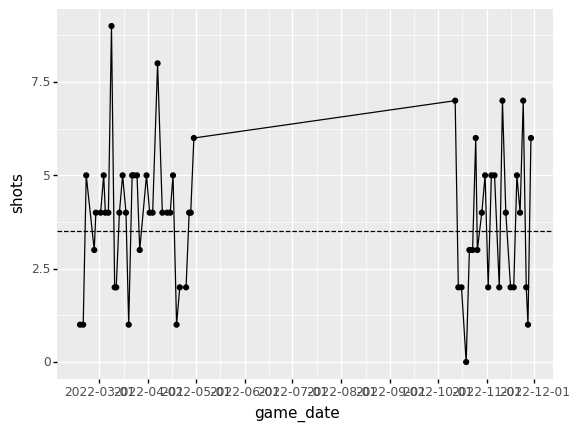

<ggplot: (125575123487)>

In [13]:
from plotnine import *

ggplot(mapping = aes(x = 'game_date', y = 'shots'), data = dat.query('player_name == "Jack Eichel"')) +\
geom_line() + geom_point() + geom_hline(aes(yintercept = 3.5), linetype = 'dashed') 